# Predicting MNIST characters with Feed-Forward Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io # used to load dataset
import time # used to evaluate time performances
import funcy # used for verbose

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler
from torch.autograd import Variable

In [2]:
# load MNIST dataset
mat_dict = scipy.io.loadmat('MNIST.mat')
# extract the images and their labels from the dictionary
images = mat_dict['input_images']
labels = mat_dict['output_labels']

In [3]:
def encode_labels(labels):
    """
    Encodes a categorical variable with one hot encoding.
    """
    possible_labels = np.arange(10)
    n_samples = labels.shape[0]
    mask = np.tile(possible_labels, (n_samples,1))
    enc_labels = (mask == labels).astype('int')
    return enc_labels

In [4]:
enc_labels = encode_labels(labels)

## Grid search with cross validation

This is an adaptation of the code of the first assignment used to perform the grid search vith cross validation. The change is due to the fact that in pytorch the loss and the optimizer must be separated from the model class that we want to train for issues in tracking the gradient. 

I tried to implement a method train for the neural network in Pytorch, but it slowed down the training speed from epoch to epoch, hence I decided to stick with the standar way of training a net and changed instead the grid search procedure. Also I use the accuracy on the validation set instead of the loss to score the various models.

I also tried to use different frameworks to perform the grid search with cross validation, namely skorch and tune, but the effort that they required was not worth the (supposed) gain in performance, since Pytorch already parallelizes training on the CPU's cores.


In [5]:
def get_K_folds(x, y, K=5):
    """
    Splits training set x with associated labels y in K (default 5) subsets.
    
    Parameters
    ----------
    x : numpy array, training set 
    y : numpy array, training labels
    K : int, number of folds (optional)
    
    Returns
    -------
    x_subsets : list of K numpy arrays
        Contains the K training subsets
    y_subsets : list of K numpy arrays
        Contains the labels of the K subsets
    """
    m = x.shape[0]
    permutation = np.random.permutation(m)
    x_shuffled = x[permutation]
    y_shuffled = y[permutation]
    
    subset_length = int(m/K)
    x_subsets = []
    y_subsets = []
    for i in range(subset_length-1):
        x_subsets.append(x_shuffled[i*subset_length: (i+1)*subset_length])
        y_subsets.append(y_shuffled[i*subset_length: (i+1)*subset_length])
    
    x_subsets.append(x_shuffled[(K-1)*subset_length:])
    y_subsets.append(x_shuffled[(K-1)*subset_length:])
    
    return x_subsets, y_subsets

In [6]:
def evaluate_HP(model, params, x_training, y_training, K, verbose):
    """
    Train and evaluates a model given some parameters using a K-fold cross validation.
    
    Parameters
    ----------
    model      : class of the predictor
        Must be instantiated as model(**params)
        Must have a "train" method like:
        net.train(x_train, y_train, x_val, y_val, train_log=True, verbose=False)
    params     : dictionary {'model_HP':value}
        hyper-parameters of the model
    x_training : numpy array, training set 
    y_training : training labels
    K          : int, number of folds
    
    """
    Kfolds_val_acc = []
    epochs_length = []
    x_subsets, y_subsets = get_K_folds(x_training, y_training, K)
    
            
    for i in range(K):
        print("Computing fold %d out of %d..."%(i+1,K))
        
        # instantiate new network
        #net = model(**params) # CHANGE HERE
        
        # validation sets for this fold
        x_val = x_subsets[i]
        y_val = y_subsets[i]
        
        # training sets
        x_train = np.array([])
        y_train = np.array([])
        for j in range(K):
            if j != i:
                if len(x_train) == 0:
                    x_train = x_subsets[j]
                    y_train = y_subsets[j]
                else:
                    x_train = np.concatenate((x_train, x_subsets[j]), axis=0)
                    y_train = np.concatenate((y_train, y_subsets[j]), axis=0)
        
        
        train_loss_log, val_loss_log, val_acc_log = train_torchNN(model, x_train, y_train, x_val, y_val, 
                                                                train_log=True, verbose=verbose, debug=False, 
                                                                train_batch_size=128, val_batch_size=128, **params) 
        # either choose the last element or the smaller (could be a good choice if early stopping is implemented)
        Kfolds_val_acc.append(val_acc_log[-1])
        epochs_length.append(len(val_acc_log)) #record the real number of training epochs

    HP_score = np.array(Kfolds_val_acc).mean()
    HP_deviation = np.array(Kfolds_val_acc).std()
    mean_epochs = int(np.mean(epochs_length))
    return HP_score, HP_deviation, mean_epochs

In [7]:
def print_parameters(params):
    print("Parameters: ")
    print('='*75)
    for key in params:
        if (key == 'lr') or (key == 'loss') or (key=='act'):
            print(key, '\t \t', params[key])
        else:
            print(key, '\t', params[key])
    print('='*75)

def print_HP_score(params,score,dev):
    print_parameters(params)
    print("Score: %.4f +/- %.4f"%(score,dev))
    


In [8]:
def GridSearchCV(model, x_training, y_training, params_comb, K_folds=5, verbose=False):
    """
    Parameters
    ----------
    model      : class of the predictor
        Must be instantiated as model(**params)
        Must have a "train" method like:
        net.train(x_train, y_train, x_val, y_val, train_log, verbose)
    params_comb: list of dictionaries {'model_HP':value}
        all combinations of hyper-parameters to be evaluated
    x_training : numpy array, training set 
    y_training : training labels
    K_folds    : int, number of folds
    
    Returns
    -------
    scoring    : list of all the mean cross-validation losses 
    deviations : list of all the std deviations of the cross-validation losses 
    mean_epochs: list of the mean number of epochs of training for each 
                 configuration of HPs
    """
    import time
    scoring = []
    deviations = []
    mean_epochs = []
    combinations = len(params_comb)
    init_time = time.time()
    for i in range(combinations):
        start = time.time()
        params = params_comb[i]
        HP_score, HP_deviation, epochs = evaluate_HP(model, params, x_training, y_training, K=K_folds, verbose=verbose)
        scoring.append(HP_score)
        deviations.append(HP_deviation)
        mean_epochs.append(epochs)
        
        print('\nParameters configuration %d out of %d'%(i+1,len(params_comb)))
        print_HP_score(params,HP_score,HP_deviation)
        finish = time.time()
        print('Time for evaluation: %.1f s'%(finish-start))
        time_to_finish = (combinations-i-1)*(finish-init_time)/(i+1)
        
        if time_to_finish > 3600:
            print('Estimated time to finish : %.2f h'%(time_to_finish/3600), '\n')
        elif time_to_finish < 3600 and time_to_finish > 60:
            print('Estimated time to finish : %.2f min'%(time_to_finish/60), '\n')
        else:
            print('Estimated time to finish : %.2f s'%(time_to_finish), '\n')
    return scoring, deviations, mean_epochs

## Fully-connected neural network in Pytorch

The architecture of the network is standard, the only notable upgrades are that I introduced the possibility of getting a custom number of hidden layers and that the output does not have an activation function because this is already done by the CrossEntropyLoss. An identical alternative would have been to use the softmax activation in the last layer and the NLL_loss as a loss function.

In [9]:
class Net(nn.Module):
    
    def __init__(self, h_sizes, out_size, dropout, n_epochs, act=F.relu):
        super(Net, self).__init__()
        # Hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))
            self.hidden.append(nn.Dropout(dropout))
        # Output layer
        self.out_layer = nn.Linear(h_sizes[-1], out_size)
        # Activation function of the hidden layers
        self.act = act
        self.n_epochs = n_epochs
        
    def forward(self, x):
        
        # Feedforward
        for layer in self.hidden:
            x = self.act(layer(x))
        out = self.out_layer(x)
        return out

My main effort has been directed towards the functions to train and evaluate the model.

In [10]:
def train_torchNN(model, x_train, y_train, x_val, y_val, train_log=True, verbose=True, debug=True, 
                  return_model = False, train_batch_size=128, val_batch_size=128, **params):
    """
    Trains a Pytorch model.
    
    Parameters
    ----------
    model: Pytorch nn.Module class with forward method
    x_train: numpy array, training data
    y_train: numpy array, training labels, one hot encoded
    x_val: numpy array, validation data
    y_val: numpy array, validation labels, one hot encoded
    train_log: bool, if True returns train loss, val loss and val accuracy for each epoch
    verbose: bool, if True prints updates of the training 10 times for each epoch
    debug: bool
        If True time-profiles the operations of forward, loss, backward prop and optimizer step
        Returns an array of containing the time profile for each batch of each epoch
    return_model: bool, if True returns the trained instance of the model 
    train_batch_size: int, number of samples in each training batch
    val_batch_size: int, number of samples in each validation batch
    **params: dictionary containing all the parameters needed by the model, the optimizer and the loss
    
    Returns
    -------
    net (if return_model): trained instance of the model 
    train_loss_log (if train_log): list, training loss for each epoch
    val_loss_log (if train_log): list, validation loss for each epoch
    val_acc_log (if train_log): list, validation accuracy for each epoch
    epoch_time (if debug): list, time to complete each epoch
    epoch_profiler (if debug): numpy array, time profile for each batch of each epoch
    
    """
    model_keys = ['n_epochs','out_size', 'h_sizes','dropout','act'] # parameters of the model
    optim_keys = ['lr','weight_decay'] # parameters of the optimizer
    model_params = {}
    optim_params = {}
    # reads out the params dictionary and fills the model and optim dictionaries
    for k in params.keys():
        if k in model_keys:
            model_params[k] = params[k]
        elif k in optim_keys:
            optim_params[k] = params[k]
    
    # init method
    net = model(**model_params)
    # init optimizer
    optimizer = params['optimizer'](net.parameters(), **optim_params)
    # define loss (params['loss'] is usually torch.nn.CrossEntropyLoss())
    loss = params['loss']
    
    # define contextual print functions activated by print flags
    verbose_print = print if verbose else lambda *a, **k: None
    debug_print  = print if debug else lambda *a, **k: None
    verbose_print("Verbose: ", verbose)
    debug_print("Debug: ", debug)
    
    # convert x and y to tensors
    x_train = torch.from_numpy(x_train)
    y_train = torch.from_numpy(y_train)
    x_val1 = torch.from_numpy(x_val)
    y_val1 = torch.from_numpy(y_val)
    # create training and validation TensorDatasets
    train_set = TensorDataset(x_train,y_train)
    val_set = TensorDataset(x_val1,y_val1)
    # create samplers for batches
    train_sampler = SubsetRandomSampler(np.arange(len(x_train)))
    val_sampler = SubsetRandomSampler(np.arange(len(x_val)))
    # create DataLoaders to load batches
    train_loader = DataLoader(train_set, train_batch_size, train_sampler, num_workers = 2)
    val_loader = DataLoader(val_set, val_batch_size, val_sampler, num_workers = 2)
    
    n_batches = len(train_loader)
    epoch_time = []
    #Time for printing
    training_start_time = time.time()
    # lists with the history of the training
    if (train_log == True):
        train_loss_log = []
        val_loss_log = []
        val_acc_log = []
    if debug:
        epoch_profiler = []
    #Loop for n_epochs
    for epoch in range(net.n_epochs):

        running_loss = 0.0
        print_every = n_batches // 10 # frequency of printing
        start_time = time.time()
        total_train_loss = 0
        batches_done = 0
        if debug:
            batch_profiler = []
        net.train() # activate dropout
        for i, data in enumerate(train_loader, 0):
            batches_done += 1
            #Get inputs
            inputs, labels = data
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            #Forward pass, backward pass, optimize
            tb_0 = time.time()
            outputs = net.forward(inputs) 
            tb_1 = time.time()
            loss_size = loss(outputs, torch.max(labels, 1)[1])
            tb_2 = time.time()
            loss_size.backward()
            tb_3 = time.time()
            optimizer.step()
            tb_4 = time.time()
            if debug:
                batch_profiler.append([tb_1-tb_0,tb_2-tb_0,tb_3-tb_0,tb_4-tb_0])
            #Print statistics
            running_loss += loss_size.item() 
            total_train_loss += loss_size.item()
            #Print every 10th batch of an epoch
            if ((i+1) % (print_every) == 0) or (i == n_batches - 1):
                verbose_print('\r'+"Epoch {}, {:d}% \t Train loss: {:.3f} took: {:.2f}s ".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / batches_done,
                        time.time() - start_time), end=' ')
                
        epoch_time.append(time.time() - start_time)
        if debug:
            epoch_profiler.append(batch_profiler)
        if (train_log == True):
            train_loss_log.append(total_train_loss/len(train_loader))
        
        
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        t_val0 = time.time()
        with torch.no_grad(): # disable gradient tracking
            net.eval() #disable dropout
            for inputs, labels in val_loader:
                #Forward pass
                val_outputs = net.forward(inputs)
                val_loss_size = loss(val_outputs, torch.max(labels, 1)[1])
                total_val_loss += val_loss_size.item()
            if (train_log == True):
                val_loss_log.append(total_val_loss/ len(val_loader))
            t_val1 = time.time() - t_val0
            if debug:
                debug_print("Val. loss: {:.3f} took: {:.2f}s".format(total_val_loss / len(val_loader),t_val1), end=' ')
            else:
                verbose_print("Val. loss: {:.3f}".format(total_val_loss / len(val_loader)), end=' ')
        t_val1 = time.time() - t_val0
        
        # evaluate also accuracy
        t_val0 = time.time()
        accuracy = eval_accuracy(net,x_val,y_val) # defined as a separate function
        if (train_log == True):
            val_acc_log.append(accuracy)
        t_val1 = time.time() - t_val0
        if debug:
            debug_print(" Val. score: {:.3f}% took: {:.2f}s".format(accuracy,t_val1))
        else:
            verbose_print(" Val. score: {:.3f}%".format(accuracy))

    verbose_print("Training finished, took {:.3f}s".format(time.time() - training_start_time))
    if train_log:
        if debug and return_model:
            epoch_profiler = np.array(epoch_profiler)
            return net, train_loss_log, val_loss_log, val_acc_log, epoch_time, epoch_profiler # used for debugging
        elif debug and not return_model:
            return train_loss_log, val_loss_log, val_acc_log, epoch_time, epoch_profiler # used for debugging
        elif not debug and return_model:
            return net, train_loss_log, val_loss_log, val_acc_log # used for final model
        else:
            return train_loss_log, val_loss_log, val_acc_log  #used during cross validation

In [11]:
def eval_accuracy(net, x_test,y_test, return_predictions=False):
    # convert x and y to tensors
    x_test = torch.from_numpy(x_test)
    y_test = torch.from_numpy(y_test)
    # create training and validation TensorDatasets
    test_set = TensorDataset(x_test,y_test)
    # create DataLoaders to load batches
    if return_predictions:
        test_loader = DataLoader(test_set, batch_size = 1)
    else:
        test_loader = DataLoader(test_set, batch_size = 16, num_workers = 2)
    correct = 0
    total = 0
    if return_predictions:
        y_pred = []
    with torch.no_grad():
        net.eval() #disable dropout
        for data in test_loader:
            images, labels = data
            outputs = net.forward(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.numpy()
            if return_predictions:
                y_pred.append(predicted)
            target_labels = np.dot(labels,np.arange(10)) #decode labels
            total += len(target_labels)
            correct += (predicted == target_labels).sum()
    accuracy = 100 * correct / total
    if return_predictions:
        return accuracy, np.array(y_pred).flatten()
    else:
        return accuracy

In [12]:
# example of parameters dictionary
net_dict = {'h_sizes' : [784,400,200],
           'out_size' : 10,
           'dropout' : 0.2,
           'loss' : torch.nn.CrossEntropyLoss(),
           'optimizer' : optim.Adamax,
           'lr' : 0.01,
           'n_epochs' : 10,
           'penalty' : 1e-5,
            'act': F.leaky_relu}

In [13]:
training_size = 54000 # 9/10 for training and validation
x_training = images[:training_size]
y_training = enc_labels[:training_size]
x_test = images[training_size:]
y_test = enc_labels[training_size:]

In [14]:
# just needed for single training
train_len = int(training_size*4/5)
x_train = x_training[:train_len]
y_train = y_training[:train_len]
x_val = x_training[train_len:]
y_val = y_training[train_len:]

Now we train a model to make sure that everything works

In [15]:
%%time
results = train_torchNN(Net, x_train, y_train, x_val, y_val, train_log=True, verbose=True, debug=True, 
                           return_model=True, train_batch_size=128, val_batch_size=128, **net_dict)
net, train_loss_log, val_loss_log, val_acc_log, epoch_time, epoch_profiler = results

Verbose:  True
Debug:  True
Epoch 1, 100% 	 Train loss: 0.274 took: 10.82s  Val. loss: 0.162 took: 0.76s  Val. score: 95.019% took: 1.97s
Epoch 2, 100% 	 Train loss: 0.126 took: 12.97s  Val. loss: 0.104 took: 0.81s  Val. score: 96.907% took: 3.56s
Epoch 3, 100% 	 Train loss: 0.090 took: 13.76s  Val. loss: 0.091 took: 0.93s  Val. score: 97.435% took: 2.16s
Epoch 4, 100% 	 Train loss: 0.074 took: 13.59s  Val. loss: 0.085 took: 0.79s  Val. score: 97.315% took: 2.49s
Epoch 5, 100% 	 Train loss: 0.059 took: 12.84s  Val. loss: 0.089 took: 0.85s  Val. score: 97.472% took: 2.38s
Epoch 6, 100% 	 Train loss: 0.050 took: 11.10s  Val. loss: 0.088 took: 0.74s  Val. score: 97.565% took: 2.08s
Epoch 7, 100% 	 Train loss: 0.043 took: 11.79s  Val. loss: 0.092 took: 0.74s  Val. score: 97.657% took: 2.19s
Epoch 8, 100% 	 Train loss: 0.034 took: 11.76s  Val. loss: 0.089 took: 0.78s  Val. score: 97.694% took: 2.32s
Epoch 9, 100% 	 Train loss: 0.031 took: 12.75s  Val. loss: 0.081 took: 0.93s  Val. score: 98

### Inspection to see if there are performance issues

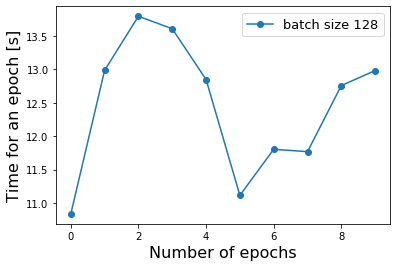

In [16]:
plt.plot(epoch_time, '-o', label = 'batch size 128')
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Time for an epoch [s]', fontsize=16)
plt.legend(fontsize=13)
plt.show()

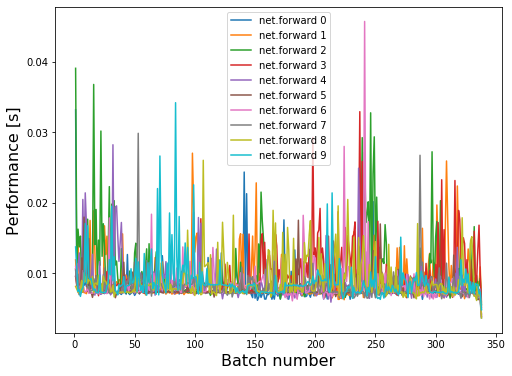

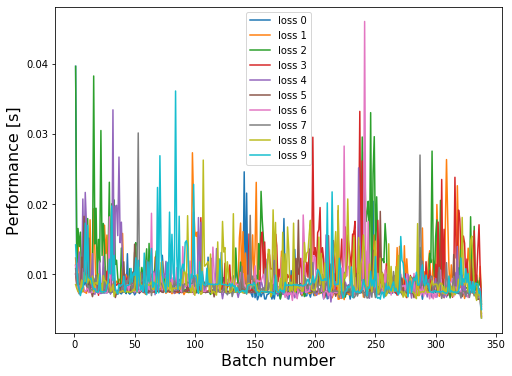

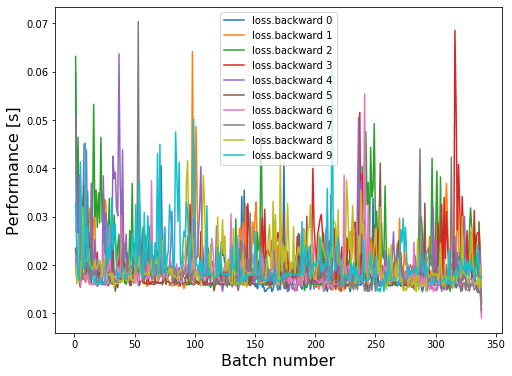

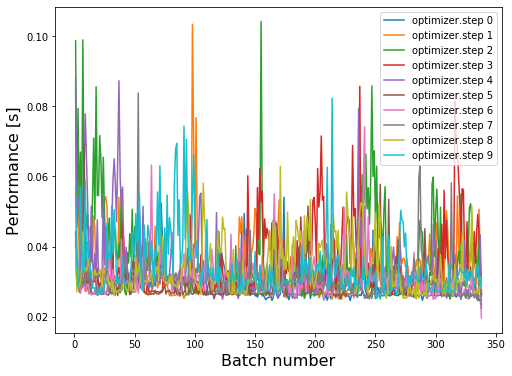

In [17]:
for j in range(epoch_profiler[0].shape[1]):
    plt.figure(figsize=(8,6))
    label_dict = {0:'net.forward',1:'loss',2:'loss.backward',3:'optimizer.step'}
    for i in range(len(epoch_profiler)):
        batch_number = np.arange(len(epoch_profiler[i]))+1
        plt.plot(batch_number, epoch_profiler[i][:,j], label = label_dict[j]+' %d'%i)
    plt.xlabel('Batch number', fontsize=16)
    plt.ylabel('Performance [s]', fontsize=16)
    plt.legend()
    plt.show()

As we can see there isn't any particular drift as a function of the epochs, hence everything works properly.

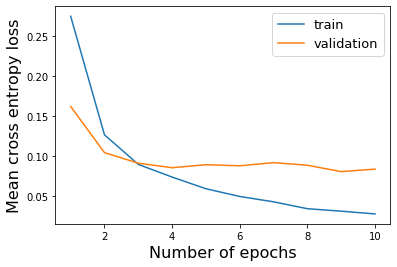

In [18]:
epochs = np.arange(len(train_loss_log))+1
plt.plot(epochs, train_loss_log, label = 'train')
plt.plot(epochs, val_loss_log, label = 'validation')
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Mean cross entropy loss', fontsize=16)
plt.legend(fontsize=13)
plt.show()

In [19]:
accuracy, predictions = eval_accuracy(net, x_test,y_test,return_predictions=True)
print("Accuracy obtained {:.2f}%".format(accuracy))

Accuracy obtained 98.03%


Some preliminar trials

Adam - Accuracy obtained 97.80% <br>
AdamW - Accuracy obtained 97.84% <br>
Adagrad - Accuracy obtained 97.65% <br>
Adamax - Accuracy obtained 97.69%

## Random search with prior distributions

Now we want to explore a method different from the grid search to tune the parameters of the model. The idea is that the more the hyperparameters we have, the less hypothesis we will be able to test given some fixed time/computational resources. 

Instead of renouncing completely of testing the effect of the various HPs on the performance, we can just renounce to do that in a systematical way and do that with a random search. 

The problem now is that even a completely random search is inefficient, in the sense that we already know what probably will be bad combinations and we would like to minimize the chances to extract those combinations; moreover some parameters may vary over different orders of magnitude. In that case using a uniform distribution would mean basically never sampling the HPs with lower magnitude, because they span a smaller interval. 

My idea is to sample from a distribution defined a priori (a.k.a. prior distribution) that encodes the bias (in the sense of hypothetical knowledge) that we have towards the combinations more promising and less promising. 

For example making some trials I noticed that few hidden layers work at least as well as many hidden layers, hence, since we like simplicity, we would like to use most of the times few layers, but sometimes to try also deeper architectures. In this perspective it is much less biased to choose a decreasing exponential distribution (on integers) for the number of hidden layers than to choose once and for all to keep the number of hidden layers fixed to 2.

The following class defines a framework to create a prior distribution for different kinds of variables (integers, continuous, categorical). I do not enter in the details since it is easier to see how it works in practice than to explain it.

In [20]:
class prior_distr():
    def __init__(self, discrete, var_type, distribution, **kwargs):
        self.discrete = discrete
        self.type = var_type
        if discrete:
            if var_type == 'int':
                if distribution == 'exp':
                    self.distr = distribution
                    self.N_min = kwargs['N_min']
                    self.N_max = kwargs['N_max']
                    self.alpha = kwargs['alpha']
                    self.elements = np.arange(self.N_min,self.N_max+1)
                elif distribution == 'uniform':
                    self.distr = distribution
                    self.N_min = kwargs['N_min']
                    self.N_max = kwargs['N_max']
                    self.elements = np.arange(self.N_min,self.N_max+1)
                    self.probabilities = np.full(len(self.elements), 1/len(self.elements))
                elif distribution == 'custom':
                    self.distr = distribution
                    self.elements = kwargs['elements']
                    if (np.abs(kwargs['p'].sum()-1) < 1e-4):
                        self.probabilities = kwargs['p']
                    else:
                        raise Exception ('Total probability must be equal to 1.')
                else:
                    raise Exception('Variable \'distribution\' must be \'exp\', \'uniform\' or \'custom\'.')
            elif var_type == 'str':
                self.elements = kwargs['elements']
                self.distr = distribution
                if distribution == 'uniform':
                    self.probabilities = np.full(len(self.elements), 1/len(self.elements))
                elif distribution == 'custom':
                    if (np.abs(kwargs['p'].sum()-1) < 1e-4):
                        self.probabilities = kwargs['p']
                    else:
                        raise Exception ('Total probability must be equal to 1.')
                else:
                    raise Exception('Variable \'distribution\' must be \'uniform\' or \'custom\'.')
            else:
                raise Exception('Type must be \'int\' or \'str\'.')
        else:
            # continuous case
            if var_type == 'float':
                if distribution == 'uniform':
                    self.distr = distribution
                    self.x_min = kwargs['x_min']
                    self.x_max = kwargs['x_max']
                elif distribution == 'log':
                    self.distr = distribution
                    self.x_min = kwargs['x_min']
                    self.x_max = kwargs['x_max']
                else:
                    raise Exception('Distribution must be \'uniform\' or \'log\'.')
            else:
                raise Exception('Continuous type must be \'float\'.')
        
    def sample(self, n_samples):
        if self.discrete == True:
            def sample_from_discrete_distr(n_samples, p_cum):
                u = np.random.rand(n_samples)
                mask = np.tile(p_cum[:,np.newaxis], (1,len(u))) > u
                samples = self.elements[np.argmax(mask, axis=0)]
                return samples

            if (self.type == 'int') and (self.distr == 'exp'): # only case in which self.probabilities is not defined
                def exp_distr(n):
                    exp_of_Ns = np.exp(-self.alpha*self.elements)
                    norm_factor = exp_of_Ns.sum() # 1/(e^alpha - 1)
                    p_of_n = np.exp(-self.alpha*n)/norm_factor
                    return p_of_n
                #Ns = self.elements
                self.probabilities = exp_distr(self.elements) # compute prob of each element
            p_cum = np.cumsum(self.probabilities)
            return sample_from_discrete_distr(n_samples, p_cum)
        else:
            if self.distr == 'uniform':
                samples = np.random.rand(n_samples)*(self.x_max - self.x_min) - self.x_min
            else:
                u = np.random.rand(n_samples)*(np.log(self.x_max)-np.log(self.x_min)) + np.log(self.x_min)
                samples = np.exp(u)
            return samples

## Prior distribution for architecture depth and number of neurons

Finally I introduced a function that given the input and output dimensions of the network and the number of hidden layers, it samples the number of neurons of each hidden layer so that on average we have a compression rate C (e.g. the ratio between neurons in one layer and the previous one) fixed to a certain quantity.

Going a bit deeper on the argument we have that since the number of neurons depends on the depth of the layer and on the compression rate, if we fix C we can obtain what on average would be the ideal depth of architecture for that compression rate.

If we have a constant compression rate, it holds: $$N(n) = N_0 \cdot C^{-n}$$  
where 
* $N(n)$ is the number of neurons in layer $n$;
* $n = 0$ for input layer;
* $n_h$ for the number of hidden layers; 
* $n = n_h + 1$ for the output layer;


We can compute the number of hidden layers required for a given C to compress the input layer in the output layer imposing $N(n_h + 1) = N_{OUT}$ and $N(0)= N_{IN}$ and use
$N(n_h +1) = N(0)\cdot C^{-(n_h + 1)} $.

We find $\overline{n_h} = \frac{1}{logC}log(\frac{N_{IN}}{N_{OUT}}) - 1 $, that is the average number of hidden layers that we MUST get sampling from a generic distribution if we want to keep the compression rate CONSTANT.

In our specific case we choose to sample from an exponential distribution $Ae^{-\alpha n}$ defined for $n > N_{min}$, (e.g. $N_{min}=2$ if we require at least 2 hidden layers). 

To find its exponent we must impose $$\sum_{n=1}^{\infty}  Ane^{- \alpha n} = \frac{e^{\alpha}}{e^{\alpha} - 1} = \overline{n_h}$$ with the normalization factor computed as 
$$\sum_{n=1}^{\infty} Ae^{- \alpha n} = 1 \longrightarrow A = \frac{1}{e^{\alpha}-1}$$

Finally we get $\alpha = log\left(\frac{\overline{n_h}}{\overline{n_h} - 1}\right)$.

Concretely what I do for sampling is:
* Fix $C$ (e.g. 2);
* Compute $\alpha$;
* Sample $n_{layers}$ from $Ae^{-\alpha n}$;
* Recompute the effective $C$ inverting the formula for $\overline{n_h}$;
* Sample for each hidden layer the number of neurons with a binomial with number of trials equal to the number of neurons on the previous layer and with success rate $1/C$.

#### APPENDIX: how to recompute $C$ 

$$N(n) = N_0 \cdot C^{-n} = N_0 \cdot e^{-n logC} = N_0 \cdot e^{-\alpha n}$$

$$\frac{N(n_h +1)}{N(0)} = \frac{N_{OUT}}{N_{IN}} = C^{-(n_h + 1)} $$

$$\frac{N_{IN}}{N_{OUT}} = C^{n_h + 1}$$

$$ C = \left(\frac{N_{IN}}{N_{OUT}}\right)^{\frac{1}{n_{hidden} + 1}}$$

In [15]:
def sample_neurons(n_samples, n_layers):
    start = 784
    end = 10
    N_neurons_samples = []
    for i in range(n_samples):
        N_neurons = [start]
        C = (start/end)**(1/(n_layers[i] + 1))
        p = 1./C # probability of not suppressing a neuron = 1/compression
        for j in range(n_layers[i]):
            n_j = np.random.binomial(N_neurons[-1],p)
            N_neurons.append(n_j)
        N_neurons_samples.append(N_neurons)
    return N_neurons_samples

In [16]:
INPUT_DIM = 784
OUTPUT_DIM = 10
C = 3

def compute_alpha(in_dim, out_dim, compression):
    n_layers = np.log(in_dim/out_dim)/np.log(compression) - 1
    alpha = np.log(n_layers/(n_layers-1))
    return alpha

alpha = compute_alpha(INPUT_DIM, OUTPUT_DIM, C)

# already discussed
n_layers_P_dict = dict(discrete=True,
                       var_type='int',
                       distribution='exp',
                       N_min = 2,
                       N_max = 50,
                       alpha=alpha)

# spans different magnitude scales, use logaritmic distribution for invariance of scale
lr_P_dict = dict(discrete=False,
                var_type='float',
                distribution='log',
                x_min = 1e-3,
                x_max = 1e-1)

# same thing here
penalty_P_dict = dict(discrete=False,
                    var_type='float',
                    distribution='log',
                    x_min = 1e-4,
                    x_max = 1e-2)

# acts on the number of neurons in a linear way, use uniform distribution
dropout_P_dict = dict(discrete=False,
                     var_type = 'float',
                     distribution='uniform',
                     x_min = 0,
                     x_max = 0.25)

# use custom distribution to encode my personal beliefs on their performances BEFORE testing them in depth
optimizer_P_dict = dict(discrete=True,
                             var_type = 'str',
                             distribution='custom',
                             elements=np.array([optim.AdamW, optim.Adam, optim.Adamax, optim.Adagrad]),
                             p = np.array([0.2,0.35,0.3,0.15]))

# use custom distribution to encode my personal beliefs on their performances BEFORE testing them in depth
activation_P_dict = dict(discrete=True,
                         var_type = 'str',
                         distribution='custom',
                         elements=np.array([F.relu,F.leaky_relu]),
                         p = np.array([0.65,0.35]))

In [321]:
P_dict = dict(lr=lr_P_dict, 
              n_layers=n_layers_P_dict, 
              penalty=penalty_P_dict, 
              dropout=dropout_P_dict, 
              optimizer=optimizer_P_dict,
              act=activation_P_dict)

In [19]:
n_samples = 100

In [323]:
params = {}
for key in P_dict.keys():
    P = prior_distr(**P_dict[key])
    if key == 'n_layers':
        n_layers= P.sample(n_samples)
        N_neurons_samples = sample_neurons(n_samples, n_layers)
        params['h_sizes'] = N_neurons_samples 
    else:
        params[key] = P.sample(n_samples)

In [324]:
# now we make a list of dictionary instead of a dictionary of lists and we also add the last constant parameters
list_of_dict = []
for i in range(n_samples):
    d = {'out_size' : 10, 'n_epochs' : 10, 'loss' : torch.nn.CrossEntropyLoss()}
    for key in params.keys():
        d[key] = params[key][i]
    list_of_dict.append(d)

### Actual HP search

In [325]:
print("Number of combinations: ", len(list_of_dict))

flag = True #set to True to see all combinations
if flag == True:
    for params in list_of_dict:
        print()
        print_parameters(params)

Number of combinations:  100

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.0063290710465702315
h_sizes 	 [784, 193, 47]
penalty 	 0.00054501486842488
dropout 	 0.0600620255163796
optimizer 	 <class 'torch.optim.adagrad.Adagrad'>
act 	 	 <function relu at 0x7f4d34c8b8c0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.07876487674635525
h_sizes 	 [784, 272, 97, 32]
penalty 	 0.00010589027861164808
dropout 	 0.016448012582696653
optimizer 	 <class 'torch.optim.adam.Adam'>
act 	 	 <function relu at 0x7f4d34c8b8c0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.07280829677046517
h_sizes 	 [784, 183, 54]
penalty 	 0.0023929898527572453
dropout 	 0.021751298533804198
optimizer 	 <class 'torch.optim.adagrad.Adagrad'>
act 	 	 <function relu at 0x7f4d34c8b8c0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.027121855278143318
h_sizes 	 [784, 259, 86, 22]
penalty 	 0.0002

optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7f4d34c8b8c0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.023619406971909812
h_sizes 	 [784, 274, 94, 37]
penalty 	 0.001479273982522288
dropout 	 0.24512489943438218
optimizer 	 <class 'torch.optim.adagrad.Adagrad'>
act 	 	 <function leaky_relu at 0x7f4d34c8bcb0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.010775198163807087
h_sizes 	 [784, 304, 139, 57, 24]
penalty 	 0.00405721974217973
dropout 	 0.00010730503789690982
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7f4d34c8b8c0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.001635176252047257
h_sizes 	 [784, 193, 47]
penalty 	 0.00019633309036954866
dropout 	 0.0015152021977760666
optimizer 	 <class 'torch.optim.adagrad.Adagrad'>
act 	 	 <function relu at 0x7f4d34c8b8c0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEnt

act 	 	 <function leaky_relu at 0x7f4d34c8bcb0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.0012714733011444605
h_sizes 	 [784, 244, 73, 26]
penalty 	 0.001713893298855269
dropout 	 0.016934535845452653
optimizer 	 <class 'torch.optim.adam.Adam'>
act 	 	 <function relu at 0x7f4d34c8b8c0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.01440920056199898
h_sizes 	 [784, 394, 212, 116, 71, 34, 17]
penalty 	 0.0001137037998456522
dropout 	 0.03412852826201293
optimizer 	 <class 'torch.optim.adamw.AdamW'>
act 	 	 <function leaky_relu at 0x7f4d34c8bcb0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.007102334544449898
h_sizes 	 [784, 260, 85, 24]
penalty 	 0.008502319368887819
dropout 	 0.12822088041935495
optimizer 	 <class 'torch.optim.adagrad.Adagrad'>
act 	 	 <function relu at 0x7f4d34c8b8c0>

Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.0011391398286245316
h

In [326]:
%%time
scoring, deviations, _ = GridSearchCV(Net, x_training, y_training, list_of_dict, K_folds=3, verbose=True)

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.490 took: 3.53s  Val. loss: 0.293  Val. score: 91.738%
Epoch 2, 100% 	 Train loss: 0.273 took: 3.86s  Val. loss: 0.239  Val. score: 92.974%
Epoch 3, 100% 	 Train loss: 0.231 took: 3.61s  Val. loss: 0.213  Val. score: 93.790%
Epoch 4, 100% 	 Train loss: 0.206 took: 3.38s  Val. loss: 0.196  Val. score: 94.360%
Epoch 5, 100% 	 Train loss: 0.189 took: 3.54s  Val. loss: 0.186  Val. score: 94.606%
Epoch 6, 100% 	 Train loss: 0.177 took: 3.45s  Val. loss: 0.182  Val. score: 94.648%
Epoch 7, 100% 	 Train loss: 0.166 took: 3.37s  Val. loss: 0.171  Val. score: 95.086%
Epoch 8, 100% 	 Train loss: 0.156 took: 3.55s  Val. loss: 0.162  Val. score: 95.164%
Epoch 9, 100% 	 Train loss: 0.150 took: 3.30s  Val. loss: 0.156  Val. score: 95.320%
Epoch 10, 100% 	 Train loss: 0.141 took: 3.64s  Val. loss: 0.153  Val. score: 95.458%
Training finished, took 67.391s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.831 took: 7.11s  Val. loss: 0.287  Val. score: 91.900%
Epoch 2, 100% 	 Train loss: 0.335 took: 6.83s  Val. loss: 0.200  Val. score: 94.222%
Epoch 3, 100% 	 Train loss: 0.247 took: 6.61s  Val. loss: 0.167  Val. score: 95.260%
Epoch 4, 100% 	 Train loss: 0.200 took: 6.62s  Val. loss: 0.146  Val. score: 95.956%
Epoch 5, 100% 	 Train loss: 0.172 took: 6.35s  Val. loss: 0.135  Val. score: 96.388%
Epoch 6, 100% 	 Train loss: 0.148 took: 6.84s  Val. loss: 0.119  Val. score: 96.898%
Epoch 7, 100% 	 Train loss: 0.132 took: 7.00s  Val. loss: 0.116  Val. score: 97.012%
Epoch 8, 100% 	 Train loss: 0.118 took: 7.21s  Val. loss: 0.112  Val. score: 97.162%
Epoch 9, 100% 	 Train loss: 0.105 took: 6.93s  Val. loss: 0.111  Val. score: 97.264%
Epoch 10, 100% 	 Train loss: 0.098 took: 6.80s  Val. loss: 0.106  Val. score: 97.402%
Training finished, took 107.391s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.568 took: 5.50s  Val. loss: 0.222  Val. score: 93.442%
Epoch 2, 100% 	 Train loss: 0.219 took: 5.23s  Val. loss: 0.151  Val. score: 95.428%
Epoch 3, 100% 	 Train loss: 0.159 took: 5.60s  Val. loss: 0.122  Val. score: 96.178%
Epoch 4, 100% 	 Train loss: 0.125 took: 5.99s  Val. loss: 0.105  Val. score: 96.892%
Epoch 5, 100% 	 Train loss: 0.103 took: 6.00s  Val. loss: 0.115  Val. score: 96.682%
Epoch 6, 100% 	 Train loss: 0.084 took: 5.76s  Val. loss: 0.104  Val. score: 97.102%
Epoch 7, 100% 	 Train loss: 0.074 took: 5.90s  Val. loss: 0.094  Val. score: 97.408%
Epoch 8, 100% 	 Train loss: 0.065 took: 5.69s  Val. loss: 0.096  Val. score: 97.384%
Epoch 9, 100% 	 Train loss: 0.056 took: 5.92s  Val. loss: 0.107  Val. score: 97.114%
Epoch 10, 100% 	 Train loss: 0.053 took: 6.02s  Val. loss: 0.099  Val. score: 97.438%
Training finished, took 94.853s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.543 took: 5.88s  Val. loss: 0.223  Val. score: 93.424%
Epoch 2, 100% 	 Train loss: 0.207 took: 5.64s  Val. loss: 0.156  Val. score: 95.404%
Epoch 3, 100% 	 Train loss: 0.143 took: 5.62s  Val. loss: 0.116  Val. score: 96.400%
Epoch 4, 100% 	 Train loss: 0.103 took: 6.34s  Val. loss: 0.118  Val. score: 96.412%
Epoch 5, 100% 	 Train loss: 0.086 took: 5.79s  Val. loss: 0.103  Val. score: 96.958%
Epoch 6, 100% 	 Train loss: 0.071 took: 6.14s  Val. loss: 0.100  Val. score: 97.198%
Epoch 7, 100% 	 Train loss: 0.057 took: 6.50s  Val. loss: 0.115  Val. score: 96.946%
Epoch 8, 100% 	 Train loss: 0.052 took: 5.76s  Val. loss: 0.094  Val. score: 97.552%
Epoch 9, 100% 	 Train loss: 0.043 took: 6.33s  Val. loss: 0.123  Val. score: 96.844%
Epoch 10, 100% 	 Train loss: 0.039 took: 6.42s  Val. loss: 0.100  Val. score: 97.366%
Training finished, took 98.388s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.379 took: 4.01s  Val. loss: 0.181  Val. score: 94.624%
Epoch 2, 100% 	 Train loss: 0.182 took: 4.19s  Val. loss: 0.162  Val. score: 94.990%
Epoch 3, 100% 	 Train loss: 0.143 took: 4.41s  Val. loss: 0.147  Val. score: 95.830%
Epoch 4, 100% 	 Train loss: 0.121 took: 4.88s  Val. loss: 0.135  Val. score: 96.160%
Epoch 5, 100% 	 Train loss: 0.109 took: 4.95s  Val. loss: 0.122  Val. score: 96.382%
Epoch 6, 100% 	 Train loss: 0.097 took: 4.97s  Val. loss: 0.115  Val. score: 96.520%
Epoch 7, 100% 	 Train loss: 0.085 took: 5.47s  Val. loss: 0.127  Val. score: 96.682%
Epoch 8, 100% 	 Train loss: 0.075 took: 4.95s  Val. loss: 0.132  Val. score: 96.634%
Epoch 9, 100% 	 Train loss: 0.073 took: 4.94s  Val. loss: 0.125  Val. score: 96.844%
Epoch 10, 100% 	 Train loss: 0.069 took: 4.85s  Val. loss: 0.119  Val. score: 96.856%
Training finished, took 77.398s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 2.361 took: 6.17s  Val. loss: 2.303  Val. score: 9.378%
Epoch 2, 100% 	 Train loss: 2.305 took: 5.74s  Val. loss: 2.307  Val. score: 10.350%
Epoch 3, 100% 	 Train loss: 2.305 took: 6.68s  Val. loss: 2.308  Val. score: 10.140%
Epoch 4, 100% 	 Train loss: 2.305 took: 9.74s  Val. loss: 2.303  Val. score: 11.358%
Epoch 5, 100% 	 Train loss: 2.305 took: 8.85s  Val. loss: 2.305  Val. score: 11.358%
Epoch 6, 100% 	 Train loss: 2.306 took: 8.84s  Val. loss: 2.304  Val. score: 9.666%
Epoch 7, 100% 	 Train loss: 2.305 took: 8.85s  Val. loss: 2.304  Val. score: 10.140%
Epoch 8, 100% 	 Train loss: 2.306 took: 9.29s  Val. loss: 2.307  Val. score: 9.666%
Epoch 9, 100% 	 Train loss: 2.305 took: 9.43s  Val. loss: 2.307  Val. score: 10.350%
Epoch 10, 100% 	 Train loss: 2.305 took: 8.84s  Val. loss: 2.302  Val. score: 11.358%
Training finished, took 123.102s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 1.2

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.471 took: 6.44s  Val. loss: 0.231  Val. score: 93.934%
Epoch 2, 100% 	 Train loss: 0.216 took: 6.36s  Val. loss: 0.162  Val. score: 95.746%
Epoch 3, 100% 	 Train loss: 0.185 took: 6.38s  Val. loss: 0.166  Val. score: 95.674%
Epoch 4, 100% 	 Train loss: 0.157 took: 7.11s  Val. loss: 0.154  Val. score: 96.502%
Epoch 5, 100% 	 Train loss: 0.144 took: 7.17s  Val. loss: 0.160  Val. score: 96.214%
Epoch 6, 100% 	 Train loss: 0.132 took: 7.83s  Val. loss: 0.156  Val. score: 96.490%
Epoch 7, 100% 	 Train loss: 0.131 took: 7.19s  Val. loss: 0.148  Val. score: 96.880%
Epoch 8, 100% 	 Train loss: 0.117 took: 7.36s  Val. loss: 0.172  Val. score: 96.430%
Epoch 9, 100% 	 Train loss: 0.124 took: 7.82s  Val. loss: 0.147  Val. score: 96.844%
Epoch 10, 100% 	 Train loss: 0.118 took: 8.23s  Val. loss: 0.188  Val. score: 96.070%
Training finished, took 113.513s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.345 took: 3.92s  Val. loss: 0.178  Val. score: 94.744%
Epoch 2, 100% 	 Train loss: 0.139 took: 3.87s  Val. loss: 0.132  Val. score: 95.770%
Epoch 3, 100% 	 Train loss: 0.091 took: 3.91s  Val. loss: 0.129  Val. score: 96.010%
Epoch 4, 100% 	 Train loss: 0.070 took: 3.53s  Val. loss: 0.108  Val. score: 96.772%
Epoch 5, 100% 	 Train loss: 0.054 took: 3.90s  Val. loss: 0.103  Val. score: 96.940%
Epoch 6, 100% 	 Train loss: 0.041 took: 3.88s  Val. loss: 0.114  Val. score: 96.904%
Epoch 7, 100% 	 Train loss: 0.039 took: 3.78s  Val. loss: 0.119  Val. score: 97.012%
Epoch 8, 100% 	 Train loss: 0.032 took: 3.85s  Val. loss: 0.123  Val. score: 96.586%
Epoch 9, 100% 	 Train loss: 0.032 took: 3.66s  Val. loss: 0.125  Val. score: 96.886%
Epoch 10, 100% 	 Train loss: 0.029 took: 3.51s  Val. loss: 0.126  Val. score: 97.036%
Training finished, took 67.441s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.488 took: 6.97s  Val. loss: 0.207  Val. score: 93.988%
Epoch 2, 100% 	 Train loss: 0.176 took: 7.64s  Val. loss: 0.171  Val. score: 95.074%
Epoch 3, 100% 	 Train loss: 0.125 took: 8.08s  Val. loss: 0.117  Val. score: 96.778%
Epoch 4, 100% 	 Train loss: 0.093 took: 7.99s  Val. loss: 0.110  Val. score: 97.042%
Epoch 5, 100% 	 Train loss: 0.073 took: 8.73s  Val. loss: 0.111  Val. score: 97.090%
Epoch 6, 100% 	 Train loss: 0.060 took: 8.17s  Val. loss: 0.105  Val. score: 97.348%
Epoch 7, 100% 	 Train loss: 0.048 took: 8.42s  Val. loss: 0.112  Val. score: 97.186%
Epoch 8, 100% 	 Train loss: 0.043 took: 8.44s  Val. loss: 0.113  Val. score: 97.204%
Epoch 9, 100% 	 Train loss: 0.031 took: 8.30s  Val. loss: 0.110  Val. score: 97.486%
Epoch 10, 100% 	 Train loss: 0.028 took: 7.95s  Val. loss: 0.122  Val. score: 97.438%
Training finished, took 122.118s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.325 took: 4.43s  Val. loss: 0.168  Val. score: 94.876%
Epoch 2, 100% 	 Train loss: 0.139 took: 4.42s  Val. loss: 0.134  Val. score: 95.908%
Epoch 3, 100% 	 Train loss: 0.102 took: 4.50s  Val. loss: 0.115  Val. score: 96.616%
Epoch 4, 100% 	 Train loss: 0.078 took: 4.76s  Val. loss: 0.099  Val. score: 96.964%
Epoch 5, 100% 	 Train loss: 0.063 took: 4.42s  Val. loss: 0.108  Val. score: 96.844%
Epoch 6, 100% 	 Train loss: 0.049 took: 4.35s  Val. loss: 0.126  Val. score: 96.538%
Epoch 7, 100% 	 Train loss: 0.041 took: 4.75s  Val. loss: 0.110  Val. score: 97.132%
Epoch 8, 100% 	 Train loss: 0.034 took: 4.65s  Val. loss: 0.119  Val. score: 96.934%
Epoch 9, 100% 	 Train loss: 0.030 took: 4.76s  Val. loss: 0.110  Val. score: 97.342%
Epoch 10, 100% 	 Train loss: 0.026 took: 4.69s  Val. loss: 0.115  Val. score: 97.222%
Training finished, took 76.334s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.910 took: 4.01s  Val. loss: 0.261  Val. score: 92.374%
Epoch 2, 100% 	 Train loss: 0.314 took: 3.83s  Val. loss: 0.208  Val. score: 94.024%
Epoch 3, 100% 	 Train loss: 0.242 took: 3.96s  Val. loss: 0.162  Val. score: 95.578%
Epoch 4, 100% 	 Train loss: 0.208 took: 3.72s  Val. loss: 0.143  Val. score: 95.812%
Epoch 5, 100% 	 Train loss: 0.184 took: 3.74s  Val. loss: 0.138  Val. score: 96.178%
Epoch 6, 100% 	 Train loss: 0.166 took: 4.11s  Val. loss: 0.136  Val. score: 96.208%
Epoch 7, 100% 	 Train loss: 0.153 took: 3.83s  Val. loss: 0.123  Val. score: 96.628%
Epoch 8, 100% 	 Train loss: 0.133 took: 3.90s  Val. loss: 0.123  Val. score: 96.682%
Epoch 9, 100% 	 Train loss: 0.126 took: 3.88s  Val. loss: 0.126  Val. score: 96.742%
Epoch 10, 100% 	 Train loss: 0.114 took: 3.83s  Val. loss: 0.120  Val. score: 96.814%
Training finished, took 72.441s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.513 took: 3.85s  Val. loss: 0.216  Val. score: 93.538%
Epoch 2, 100% 	 Train loss: 0.215 took: 3.80s  Val. loss: 0.158  Val. score: 95.278%
Epoch 3, 100% 	 Train loss: 0.158 took: 3.76s  Val. loss: 0.129  Val. score: 96.124%
Epoch 4, 100% 	 Train loss: 0.129 took: 3.82s  Val. loss: 0.115  Val. score: 96.598%
Epoch 5, 100% 	 Train loss: 0.107 took: 3.49s  Val. loss: 0.105  Val. score: 97.066%
Epoch 6, 100% 	 Train loss: 0.093 took: 3.45s  Val. loss: 0.100  Val. score: 97.120%
Epoch 7, 100% 	 Train loss: 0.082 took: 3.86s  Val. loss: 0.092  Val. score: 97.324%
Epoch 8, 100% 	 Train loss: 0.075 took: 3.82s  Val. loss: 0.089  Val. score: 97.420%
Epoch 9, 100% 	 Train loss: 0.067 took: 3.86s  Val. loss: 0.088  Val. score: 97.570%
Epoch 10, 100% 	 Train loss: 0.062 took: 3.85s  Val. loss: 0.099  Val. score: 97.288%
Training finished, took 67.408s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.734 took: 5.53s  Val. loss: 0.236  Val. score: 93.604%
Epoch 2, 100% 	 Train loss: 0.296 took: 5.65s  Val. loss: 0.202  Val. score: 94.438%
Epoch 3, 100% 	 Train loss: 0.229 took: 5.38s  Val. loss: 0.163  Val. score: 95.494%
Epoch 4, 100% 	 Train loss: 0.194 took: 5.96s  Val. loss: 0.155  Val. score: 95.764%
Epoch 5, 100% 	 Train loss: 0.175 took: 5.26s  Val. loss: 0.145  Val. score: 96.166%
Epoch 6, 100% 	 Train loss: 0.153 took: 5.23s  Val. loss: 0.146  Val. score: 96.262%
Epoch 7, 100% 	 Train loss: 0.138 took: 5.24s  Val. loss: 0.154  Val. score: 96.046%
Epoch 8, 100% 	 Train loss: 0.126 took: 5.75s  Val. loss: 0.139  Val. score: 96.298%
Epoch 9, 100% 	 Train loss: 0.121 took: 5.89s  Val. loss: 0.160  Val. score: 95.728%
Epoch 10, 100% 	 Train loss: 0.112 took: 5.38s  Val. loss: 0.133  Val. score: 96.616%
Training finished, took 96.052s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.526 took: 3.19s  Val. loss: 0.273  Val. score: 92.062%
Epoch 2, 100% 	 Train loss: 0.300 took: 3.59s  Val. loss: 0.212  Val. score: 93.706%
Epoch 3, 100% 	 Train loss: 0.254 took: 3.41s  Val. loss: 0.189  Val. score: 94.264%
Epoch 4, 100% 	 Train loss: 0.226 took: 3.25s  Val. loss: 0.169  Val. score: 94.906%
Epoch 5, 100% 	 Train loss: 0.209 took: 3.18s  Val. loss: 0.157  Val. score: 95.206%
Epoch 6, 100% 	 Train loss: 0.191 took: 3.58s  Val. loss: 0.149  Val. score: 95.362%
Epoch 7, 100% 	 Train loss: 0.181 took: 3.21s  Val. loss: 0.142  Val. score: 95.554%
Epoch 8, 100% 	 Train loss: 0.169 took: 3.52s  Val. loss: 0.136  Val. score: 95.764%
Epoch 9, 100% 	 Train loss: 0.160 took: 3.53s  Val. loss: 0.133  Val. score: 95.956%
Epoch 10, 100% 	 Train loss: 0.155 took: 3.18s  Val. loss: 0.126  Val. score: 96.046%
Training finished, took 64.150s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 2.911 took: 11.05s  Val. loss: 2.240  Val. score: 19.501%
Epoch 2, 100% 	 Train loss: 6.325 took: 11.09s  Val. loss: 2.124  Val. score: 24.163%
Epoch 3, 100% 	 Train loss: 2.331 took: 11.94s  Val. loss: 1.903  Val. score: 24.211%
Epoch 4, 100% 	 Train loss: 1.952 took: 11.27s  Val. loss: 1.742  Val. score: 28.585%
Epoch 5, 100% 	 Train loss: 1.839 took: 11.09s  Val. loss: 1.671  Val. score: 32.215%
Epoch 6, 100% 	 Train loss: 1.720 took: 11.08s  Val. loss: 1.475  Val. score: 37.880%
Epoch 7, 100% 	 Train loss: 1.566 took: 11.59s  Val. loss: 1.436  Val. score: 38.780%
Epoch 8, 100% 	 Train loss: 1.599 took: 11.08s  Val. loss: 1.430  Val. score: 45.296%
Epoch 9, 100% 	 Train loss: 1.524 took: 11.09s  Val. loss: 1.375  Val. score: 44.060%
Epoch 10, 100% 	 Train loss: 9.458 took: 12.90s  Val. loss: 16.467  Val. score: 9.072%
Training finished, took 171.723s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Tr

Epoch 9, 100% 	 Train loss: 224428.967 took: 13.40s  Val. loss: 35545.162  Val. score: 9.954%
Epoch 10, 100% 	 Train loss: 631450.098 took: 12.09s  Val. loss: 117702.880  Val. score: 9.642%
Training finished, took 187.447s

Parameters configuration 75 out of 100
Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.07853705839303185
h_sizes 	 [784, 504, 312, 208, 133, 93, 59, 42, 26, 17]
penalty 	 0.00047760923871105357
dropout 	 0.016873261959553826
optimizer 	 <class 'torch.optim.adam.Adam'>
act 	 	 <function leaky_relu at 0x7f4d34c8bcb0>
Loss: 9.8364 +/- 0.2102
Time for evaluation: 555.1 s
Estimated time to finish : 2.32 h 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.773 took: 4.09s  Val. loss: 0.370  Val. score: 89.488%
Epoch 2, 100% 	 Train loss: 0.399 took: 4.43s  Val. loss: 0.288  Val. score: 91.612%
Epoch 3, 100% 	 Train loss: 0.330 took: 4.55s  Val. loss: 0.252  Val. score: 92.728%
Epoch 4, 100% 	 Train loss: 0.297 took: 4

Epoch 2, 100% 	 Train loss: 0.526 took: 17.80s  Val. loss: 0.386  Val. score: 92.170%
Epoch 3, 100% 	 Train loss: 0.298 took: 19.25s  Val. loss: 0.303  Val. score: 92.554%
Epoch 4, 100% 	 Train loss: 0.205 took: 20.66s  Val. loss: 0.237  Val. score: 94.924%
Epoch 5, 100% 	 Train loss: 0.154 took: 19.67s  Val. loss: 0.227  Val. score: 95.722%
Epoch 6, 100% 	 Train loss: 0.125 took: 20.80s  Val. loss: 0.223  Val. score: 95.638%
Epoch 7, 100% 	 Train loss: 0.103 took: 21.11s  Val. loss: 0.209  Val. score: 96.040%
Epoch 8, 100% 	 Train loss: 0.086 took: 20.80s  Val. loss: 0.215  Val. score: 96.184%
Epoch 9, 100% 	 Train loss: 0.080 took: 20.24s  Val. loss: 0.209  Val. score: 96.472%
Epoch 10, 100% 	 Train loss: 0.063 took: 20.73s  Val. loss: 0.223  Val. score: 96.430%
Training finished, took 269.457s

Parameters configuration 80 out of 100
Parameters: 
out_size 	 10
n_epochs 	 10
loss 	 	 CrossEntropyLoss()
lr 	 	 0.0052709222854375555
h_sizes 	 [784, 539, 361, 237, 164, 108, 69, 48, 38, 2

Epoch 1, 100% 	 Train loss: 0.872 took: 8.79s  Val. loss: 0.385  Val. score: 90.628%
Epoch 2, 100% 	 Train loss: 0.364 took: 8.94s  Val. loss: 0.321  Val. score: 92.476%
Epoch 3, 100% 	 Train loss: 0.310 took: 11.33s  Val. loss: 0.277  Val. score: 92.968%
Epoch 4, 100% 	 Train loss: 0.273 took: 9.60s  Val. loss: 0.272  Val. score: 93.742%
Epoch 5, 100% 	 Train loss: 0.223 took: 11.19s  Val. loss: 0.210  Val. score: 94.804%
Epoch 6, 100% 	 Train loss: 0.267 took: 8.79s  Val. loss: 0.274  Val. score: 93.970%
Epoch 7, 100% 	 Train loss: 0.385 took: 10.62s  Val. loss: 0.617  Val. score: 83.715%
Epoch 8, 100% 	 Train loss: 1.351 took: 9.68s  Val. loss: 2.362  Val. score: 9.768%
Epoch 9, 100% 	 Train loss: 2.536 took: 8.75s  Val. loss: 1.976  Val. score: 29.881%
Epoch 10, 100% 	 Train loss: 61.174 took: 8.62s  Val. loss: 1.906  Val. score: 29.059%
Training finished, took 143.065s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.818 took: 8.09s  Val. loss: 0.377  Val.

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.910 took: 4.05s  Val. loss: 0.523  Val. score: 85.647%
Epoch 2, 100% 	 Train loss: 0.527 took: 4.40s  Val. loss: 0.425  Val. score: 88.132%
Epoch 3, 100% 	 Train loss: 0.461 took: 4.30s  Val. loss: 0.383  Val. score: 89.194%
Epoch 4, 100% 	 Train loss: 0.420 took: 4.32s  Val. loss: 0.358  Val. score: 89.854%
Epoch 5, 100% 	 Train loss: 0.390 took: 4.39s  Val. loss: 0.340  Val. score: 90.232%
Epoch 6, 100% 	 Train loss: 0.368 took: 4.19s  Val. loss: 0.322  Val. score: 90.832%
Epoch 7, 100% 	 Train loss: 0.355 took: 4.38s  Val. loss: 0.310  Val. score: 91.042%
Epoch 8, 100% 	 Train loss: 0.340 took: 4.33s  Val. loss: 0.300  Val. score: 91.426%
Epoch 9, 100% 	 Train loss: 0.325 took: 4.32s  Val. loss: 0.291  Val. score: 91.732%
Epoch 10, 100% 	 Train loss: 0.314 took: 3.97s  Val. loss: 0.283  Val. score: 91.864%
Training finished, took 77.109s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.717 took: 3.64s  Val. loss: 0.281  Val. score: 91.552%
Epoch 2, 100% 	 Train loss: 0.339 took: 4.02s  Val. loss: 0.256  Val. score: 92.680%
Epoch 3, 100% 	 Train loss: 0.292 took: 4.25s  Val. loss: 0.217  Val. score: 93.748%
Epoch 4, 100% 	 Train loss: 0.264 took: 5.12s  Val. loss: 0.208  Val. score: 94.138%
Epoch 5, 100% 	 Train loss: 0.237 took: 4.63s  Val. loss: 0.199  Val. score: 94.588%
Epoch 6, 100% 	 Train loss: 0.230 took: 5.04s  Val. loss: 0.218  Val. score: 94.456%
Epoch 7, 100% 	 Train loss: 0.209 took: 4.99s  Val. loss: 0.217  Val. score: 94.108%
Epoch 8, 100% 	 Train loss: 0.199 took: 4.79s  Val. loss: 0.182  Val. score: 95.020%
Epoch 9, 100% 	 Train loss: 0.189 took: 5.06s  Val. loss: 0.227  Val. score: 94.516%
Epoch 10, 100% 	 Train loss: 0.191 took: 4.63s  Val. loss: 0.194  Val. score: 94.726%
Training finished, took 75.251s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 1

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 1.007 took: 10.77s  Val. loss: 0.495  Val. score: 84.837%
Epoch 2, 100% 	 Train loss: 0.352 took: 10.85s  Val. loss: 0.255  Val. score: 92.704%
Epoch 3, 100% 	 Train loss: 0.231 took: 11.76s  Val. loss: 0.208  Val. score: 94.006%
Epoch 4, 100% 	 Train loss: 0.168 took: 11.89s  Val. loss: 0.168  Val. score: 95.206%
Epoch 5, 100% 	 Train loss: 0.130 took: 10.90s  Val. loss: 0.150  Val. score: 95.794%
Epoch 6, 100% 	 Train loss: 0.106 took: 10.92s  Val. loss: 0.145  Val. score: 96.106%
Epoch 7, 100% 	 Train loss: 0.086 took: 10.93s  Val. loss: 0.154  Val. score: 95.710%
Epoch 8, 100% 	 Train loss: 0.070 took: 11.84s  Val. loss: 0.132  Val. score: 96.340%
Epoch 9, 100% 	 Train loss: 0.056 took: 11.21s  Val. loss: 0.152  Val. score: 95.938%
Epoch 10, 100% 	 Train loss: 0.043 took: 11.74s  Val. loss: 0.139  Val. score: 96.526%
Training finished, took 167.029s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Tr

In [327]:
np.save('HP_scoring', scoring) # to make sure of not losing the results of the grid search
np.save('HP_deviations', deviations) 
np.save('dict_list', list_of_dict)

## Results analysis before second grid search

In [705]:
scoring = np.load('HP_scoring.npy')
deviations = np.load('HP_deviations.npy')
list_of_dict = np.load('dict_list.npy', allow_pickle=True)

### Optimizer vs learning rate 


In [706]:
learning_rates = np.zeros(n_samples)
optimizers = []
opt_dict = {optim.AdamW:'AdamW', optim.Adam:'Adam', optim.Adamax:'Adamax', optim.Adagrad:'Adagrad'}
colors_dict = {'AdamW':'b', 'Adam':'g', 'Adamax':'r', 'Adagrad':'c'}
act_dict = {F.relu:'relu',F.leaky_relu:'leaky relu'}
colors_dict2 = {'relu':'b', 'leaky relu':'r'}
colors = []
colors2 = []
n_layers = []
dropout = np.zeros(n_samples)
penalty = np.zeros(n_samples)
act = []
for i in range(n_samples):
    d = list_of_dict[i]
    learning_rates[i] = d['lr']
    dropout[i] = d['dropout']
    penalty[i] = d['penalty']
    n_layers.append(len(d['h_sizes'])-1)
    optimizers.append(opt_dict[d['optimizer']])
    colors.append(colors_dict[optimizers[-1]])
    act.append(act_dict[d['act']])
    colors2.append(colors_dict2[act[-1]])

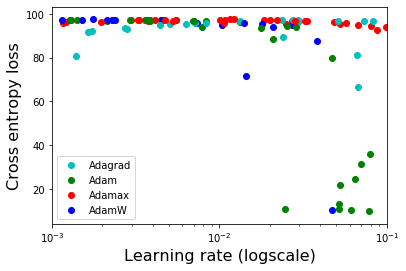

In [707]:
label_record = []
for i in range(n_samples):
    if optimizers[i] in label_record:
        plt.scatter(learning_rates[i],scoring[i],c=colors[i])
    else:
        plt.scatter(learning_rates[i],scoring[i],c=colors[i], label = optimizers[i])
        label_record.append(optimizers[i])
plt.xlabel('Learning rate (logscale)', fontsize=16)
plt.xlim(1e-3,1e-1)
plt.ylabel('Cross entropy loss', fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()

It seems that Adamax is the most stable optimizer, hence in the second grid search we are going to use just that.

### Number of layers

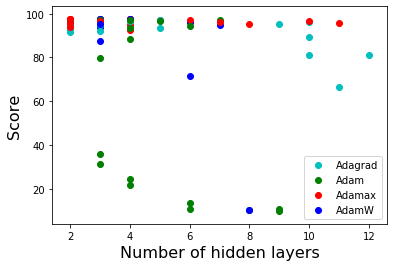

In [708]:
label_record = []
for i in range(n_samples):
    if optimizers[i] in label_record:
        plt.scatter(n_layers[i],scoring[i],c=colors[i])
    else:
        plt.scatter(n_layers[i],scoring[i],c=colors[i], label = optimizers[i])
        label_record.append(optimizers[i])
plt.ylabel('Score', fontsize=16)
plt.xlabel('Number of hidden layers', fontsize=16)
plt.legend()
plt.show()

Again here the majority of bad performances of Adam seems to be related also to the learning rate. In the next plot I try a visualization using both color and size of the markers to make sense of this situation and understand if that is really the case.

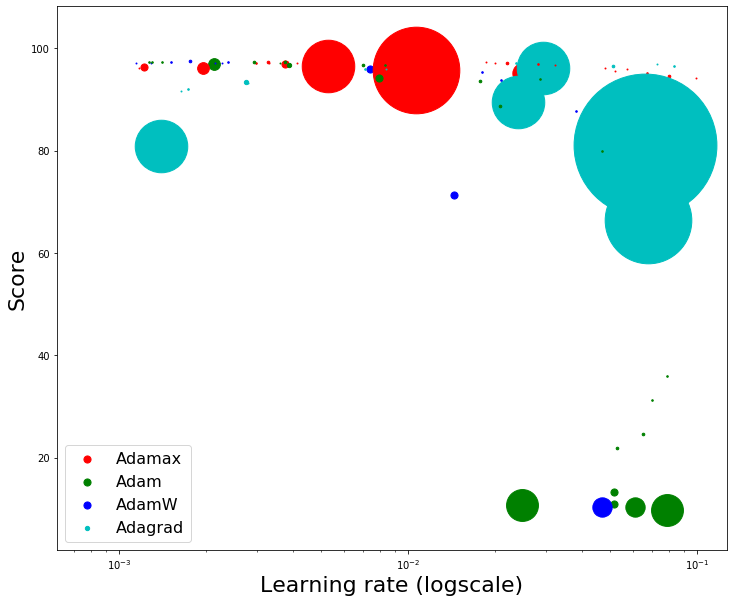

In [737]:
plt.figure(figsize=(12,10))
label_record = []
for i in range(n_samples):
    if optimizers[i] in label_record :
        plt.scatter(learning_rates[i],scoring[i], s=1.75*np.exp(n_layers[i]-1.25), c=colors[i], marker='.')
    elif ((n_layers[i] <= 4) or (n_layers[i]>6)):
        plt.scatter(learning_rates[i],scoring[i], s=1.75*np.exp(n_layers[i]-1.25), c=colors[i], marker='.')
    else:
        plt.scatter(learning_rates[i],scoring[i], s=1.75*np.exp(n_layers[i]-1.25), c=colors[i], label = optimizers[i], marker='.')
        label_record.append(optimizers[i])
plt.xscale('log')
plt.ylabel('Score', fontsize=22)
plt.xlabel('Learning rate (logscale)', fontsize=22)
plt.legend(fontsize=16)
plt.show()

It is a bit difficult to visualize, but we can understand that a good portion of the models with bad performances has a combination of high learning rate and high number of number of layers. Again Adamax confirms itself as the most stable optimizer and it seems that the number of hidden layers can be shrinked even more, considering mainly networks with 2 or 3 hidden layers. Finally I will restrict the learning rate between $10^{-3}$ and $10^{-2}$.

### Activation function

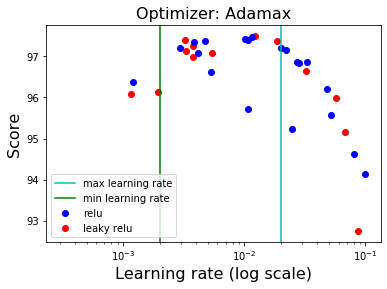

In [59]:
label_record = []
for i in range(n_samples):
    if optimizers[i] == 'Adamax':
        if act[i] in label_record:
            plt.scatter(learning_rates[i], scoring[i],c=colors2[i])
        else:
            plt.scatter(learning_rates[i], scoring[i],c=colors2[i], label = act[i])
            label_record.append(act[i])
            
plt.ylabel('Score', fontsize=16)
plt.xlabel('Learning rate (log scale)', fontsize=16)
plt.xscale('log')
plt.axvline(2*10**(-2), color = 'c', label='max learning rate')
plt.axvline(2*10**(-3), color = 'g', label='min learning rate')
plt.legend(loc='lower left')
plt.title('Optimizer: Adamax', fontsize=16)
plt.show()

There doesn't seem to be a clear dependence of the performances on the activation function. Instead we can idenfity the interval in which the activation functions seem to be more performing, that is between $2\cdot10^{-3}$ and  $2\cdot10^{-2}$. I will restrict the learning rates of the next grid search to that interval.

### Dropout

How dropout affects performances of the models that use Adamax and have a learning rate between $2\cdot10^{-3}$ and  $2\cdot10^{-2}$ ?

In [88]:
drop_lr = []
drop_act = []
drop_scoring = []
drop_dropout = []
drop_colors = []
drop_n_layers = []
drop_penalty = []
for i in range(n_samples):
    if (optimizers[i]=='Adamax') and (learning_rates[i]>2*10**(-3)) and (learning_rates[i]<2*10**(-2)):
        drop_lr.append(learning_rates[i])
        drop_act.append(act[i])
        drop_scoring.append(scoring[i])
        drop_dropout.append(dropout[i])
        drop_colors.append(colors2[i])
        drop_n_layers.append(n_layers[i])
        drop_penalty.append(penalty[i])

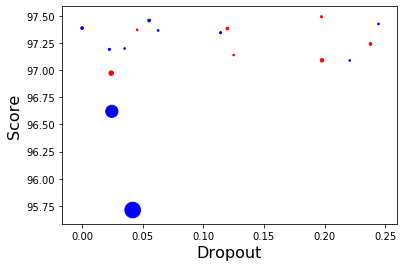

In [89]:
plt.scatter(drop_dropout,drop_scoring,c=drop_colors,s=np.exp(np.array(drop_n_layers)/2))
plt.ylabel('Score', fontsize=16)
plt.xlabel('Dropout', fontsize=16)
plt.show()

In [90]:
print("Number of hidden layers considered: ", drop_n_layers)

Number of hidden layers considered:  [4, 4, 3, 6, 3, 5, 11, 2, 4, 4, 2, 2, 3, 2, 2, 10, 2]


No particular relationship emerges except from the fact that a great number of hidden layers is bad performing.

### Penalty (weight decay)

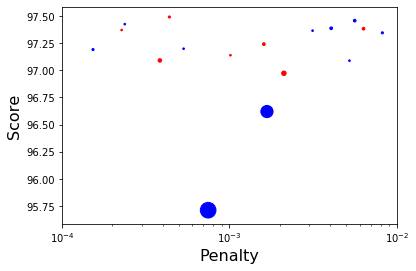

In [93]:
plt.scatter(drop_penalty,drop_scoring,c=drop_colors,s=np.exp(np.array(drop_n_layers)/2))
plt.ylabel('Score', fontsize=16)
plt.xlabel('Penalty', fontsize=16)
plt.xlim(10**(-4),10**(-2))
plt.xscale('log')
plt.show()

Again no particular trend emerges.

## Final random search

In [476]:
INPUT_DIM = 784
OUTPUT_DIM = 10
C = 3.5

def compute_alpha(in_dim, out_dim, compression):
    n_layers = np.log(in_dim/out_dim)/np.log(compression) - 1
    alpha = np.log(n_layers/(n_layers-1))
    return alpha

alpha = compute_alpha(INPUT_DIM, OUTPUT_DIM, C)

# already discussed
n_layers_P_dict = dict(discrete=True,
                       var_type='int',
                       distribution='exp',
                       N_min = 2,
                       N_max = 50,
                       alpha=alpha)

# spans different magnitude scales, use logaritmic distribution for invariance of scale
lr_P_dict = dict(discrete=False,
                var_type='float',
                distribution='log',
                x_min = 2*1e-3,
                x_max = 2*1e-2)

# same thing here
penalty_P_dict = dict(discrete=False,
                    var_type='float',
                    distribution='log',
                    x_min = 1e-4,
                    x_max = 1e-2)

# acts on the number of neurons in a linear way, use uniform distribution
dropout_P_dict = dict(discrete=False,
                     var_type = 'float',
                     distribution='uniform',
                     x_min = 0,
                     x_max = 0.25)

# use custom distribution to encode my personal beliefs on their performances BEFORE testing them in depth
optimizer_P_dict = dict(discrete=True,
                             var_type = 'str',
                             distribution='custom',
                             elements=np.array([ optim.Adamax]),
                             p = np.array([1]))

# use custom distribution to encode my personal beliefs on their performances BEFORE testing them in depth
activation_P_dict = dict(discrete=True,
                         var_type = 'str',
                         distribution='custom',
                         elements=np.array([F.relu,F.leaky_relu]),
                         p = np.array([0.65,0.35]))

In [477]:
P_dict = dict(lr=lr_P_dict, 
              n_layers=n_layers_P_dict, 
              penalty=penalty_P_dict, 
              dropout=dropout_P_dict, 
              optimizer=optimizer_P_dict,
              act=activation_P_dict)

In [478]:
n_samples = 100

In [479]:
params = {}
for key in P_dict.keys():
    P = prior_distr(**P_dict[key])
    if key == 'n_layers':
        n_layers= P.sample(n_samples)
        N_neurons_samples = sample_neurons(n_samples, n_layers)
        params['h_sizes'] = N_neurons_samples 
    else:
        params[key] = P.sample(n_samples)

In [480]:
# now we make a list of dictionary instead of a dictionary of lists and we also add the last constant parameters
list_of_dict = []
for i in range(n_samples):
    d = {'out_size' : 10, 'n_epochs' : 15, 'loss' : torch.nn.CrossEntropyLoss()}
    for key in params.keys():
        d[key] = params[key][i]
    list_of_dict.append(d)

In [481]:
print("Number of combinations: ", len(list_of_dict))

flag = True #set to True to see all combinations
if flag == True:
    for params in list_of_dict:
        print()
        print_parameters(params)

Number of combinations:  100

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.004586111167879296
h_sizes 	 [784, 181, 59]
penalty 	 0.005109993930533217
dropout 	 0.08525392756359634
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.01524403599320976
h_sizes 	 [784, 350, 142, 63, 26]
penalty 	 0.0003476412617405241
dropout 	 0.13420882014385638
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.01063277965349671
h_sizes 	 [784, 162, 47]
penalty 	 0.00046322720693077257
dropout 	 0.10513450663009169
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.002127154319064286
h_sizes 	 [784, 174, 33]
penalty 	 0.0059

dropout 	 0.06919644772687822
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.0047514779126872735
h_sizes 	 [784, 410, 221, 121, 53, 25, 16]
penalty 	 0.006110586067950274
dropout 	 0.004200560732935177
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.009170325296149398
h_sizes 	 [784, 427, 245, 135, 65, 38, 18]
penalty 	 0.0009695171160236083
dropout 	 0.09456445608021896
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.008725959805404075
h_sizes 	 [784, 269, 79, 26]
penalty 	 0.008162834979702554
dropout 	 0.14902353260290122
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function leaky_relu at 0x7ff448094cb0>

Paramete

dropout 	 0.17879078646643765
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.009752196267247772
h_sizes 	 [784, 324, 134, 50, 15]
penalty 	 0.0003826375431677099
dropout 	 0.24246159332502737
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.013909282948619515
h_sizes 	 [784, 338, 153, 61, 30]
penalty 	 0.0015819485864566184
dropout 	 0.14965454364809813
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.016388848637946613
h_sizes 	 [784, 167, 47]
penalty 	 0.00012218545700531748
dropout 	 0.1911133678657312
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>

Parameters: 
out_size 	 10
n_epochs 

In [482]:
%%time
scoring, deviations, _ = GridSearchCV(Net, x_training, y_training, list_of_dict, K_folds=3, verbose=True)

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.426 took: 4.97s  Val. loss: 0.219  Val. score: 93.311%
Epoch 2, 100% 	 Train loss: 0.197 took: 8.34s  Val. loss: 0.165  Val. score: 95.017%
Epoch 3, 100% 	 Train loss: 0.144 took: 5.82s  Val. loss: 0.131  Val. score: 95.917%
Epoch 4, 100% 	 Train loss: 0.117 took: 5.07s  Val. loss: 0.120  Val. score: 96.144%
Epoch 5, 100% 	 Train loss: 0.091 took: 5.04s  Val. loss: 0.111  Val. score: 96.528%
Epoch 6, 100% 	 Train loss: 0.076 took: 5.17s  Val. loss: 0.101  Val. score: 96.772%
Epoch 7, 100% 	 Train loss: 0.066 took: 4.97s  Val. loss: 0.098  Val. score: 96.906%
Epoch 8, 100% 	 Train loss: 0.058 took: 5.14s  Val. loss: 0.093  Val. score: 97.028%
Epoch 9, 100% 	 Train loss: 0.048 took: 5.15s  Val. loss: 0.091  Val. score: 97.139%
Epoch 10, 100% 	 Train loss: 0.042 took: 4.74s  Val. loss: 0.092  Val. score: 97.278%
Epoch 11, 100% 	 Train loss: 0.038 took: 5.16s  Val. loss: 0.090  Val. score: 97.211%
Epoch 12, 100% 	 Tr

Epoch 13, 100% 	 Train loss: 0.103 took: 4.34s  Val. loss: 0.105  Val. score: 96.889%
Epoch 14, 100% 	 Train loss: 0.099 took: 4.52s  Val. loss: 0.102  Val. score: 96.994%
Epoch 15, 100% 	 Train loss: 0.092 took: 4.65s  Val. loss: 0.101  Val. score: 97.061%
Training finished, took 117.040s
Computing fold 3 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.751 took: 4.56s  Val. loss: 0.338  Val. score: 90.417%
Epoch 2, 100% 	 Train loss: 0.368 took: 4.41s  Val. loss: 0.250  Val. score: 92.783%
Epoch 3, 100% 	 Train loss: 0.290 took: 4.30s  Val. loss: 0.205  Val. score: 93.933%
Epoch 4, 100% 	 Train loss: 0.243 took: 4.37s  Val. loss: 0.179  Val. score: 94.594%
Epoch 5, 100% 	 Train loss: 0.214 took: 4.58s  Val. loss: 0.158  Val. score: 95.267%
Epoch 6, 100% 	 Train loss: 0.188 took: 4.31s  Val. loss: 0.143  Val. score: 95.672%
Epoch 7, 100% 	 Train loss: 0.171 took: 4.51s  Val. loss: 0.135  Val. score: 96.017%
Epoch 8, 100% 	 Train loss: 0.159 took: 4.52s  Val. loss: 0.123  Val. 

Epoch 1, 100% 	 Train loss: 0.431 took: 4.54s  Val. loss: 0.218  Val. score: 93.450%
Epoch 2, 100% 	 Train loss: 0.199 took: 4.69s  Val. loss: 0.149  Val. score: 95.567%
Epoch 3, 100% 	 Train loss: 0.142 took: 4.51s  Val. loss: 0.123  Val. score: 96.200%
Epoch 4, 100% 	 Train loss: 0.111 took: 4.68s  Val. loss: 0.111  Val. score: 96.656%
Epoch 5, 100% 	 Train loss: 0.089 took: 5.05s  Val. loss: 0.101  Val. score: 96.906%
Epoch 6, 100% 	 Train loss: 0.077 took: 5.05s  Val. loss: 0.101  Val. score: 96.989%
Epoch 7, 100% 	 Train loss: 0.065 took: 5.07s  Val. loss: 0.097  Val. score: 97.222%
Epoch 8, 100% 	 Train loss: 0.056 took: 4.75s  Val. loss: 0.101  Val. score: 97.156%
Epoch 9, 100% 	 Train loss: 0.050 took: 5.13s  Val. loss: 0.097  Val. score: 97.256%
Epoch 10, 100% 	 Train loss: 0.042 took: 5.14s  Val. loss: 0.097  Val. score: 97.400%
Epoch 11, 100% 	 Train loss: 0.036 took: 5.11s  Val. loss: 0.093  Val. score: 97.450%
Epoch 12, 100% 	 Train loss: 0.034 took: 4.90s  Val. loss: 0.09

Epoch 14, 100% 	 Train loss: 0.053 took: 4.81s  Val. loss: 0.081  Val. score: 97.644%
Epoch 15, 100% 	 Train loss: 0.049 took: 4.95s  Val. loss: 0.087  Val. score: 97.600%
Training finished, took 124.277s

Parameters configuration 9 out of 100
Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.005553663266334762
h_sizes 	 [784, 201, 45]
penalty 	 0.0033449836450673755
dropout 	 0.22928445893051744
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function leaky_relu at 0x7ff448094cb0>
Score: 97.5630 +/- 0.0857
Time for evaluation: 371.8 s
Estimated time to finish : 11.47 h 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.763 took: 8.19s  Val. loss: 0.296  Val. score: 90.961%
Epoch 2, 100% 	 Train loss: 0.323 took: 8.24s  Val. loss: 0.193  Val. score: 94.122%
Epoch 3, 100% 	 Train loss: 0.229 took: 8.19s  Val. loss: 0.147  Val. score: 95.561%
Epoch 4, 100% 	 Train loss: 0.178 took: 8.76s  Val. loss: 0.131  Val. score: 96.011%


Epoch 4, 100% 	 Train loss: 0.124 took: 6.23s  Val. loss: 0.110  Val. score: 96.867%
Epoch 5, 100% 	 Train loss: 0.105 took: 6.36s  Val. loss: 0.103  Val. score: 97.133%
Epoch 6, 100% 	 Train loss: 0.091 took: 6.26s  Val. loss: 0.100  Val. score: 97.189%
Epoch 7, 100% 	 Train loss: 0.082 took: 6.57s  Val. loss: 0.095  Val. score: 97.467%
Epoch 8, 100% 	 Train loss: 0.075 took: 5.93s  Val. loss: 0.098  Val. score: 97.572%
Epoch 9, 100% 	 Train loss: 0.072 took: 5.98s  Val. loss: 0.093  Val. score: 97.572%
Epoch 10, 100% 	 Train loss: 0.063 took: 5.89s  Val. loss: 0.095  Val. score: 97.667%
Epoch 11, 100% 	 Train loss: 0.060 took: 6.67s  Val. loss: 0.099  Val. score: 97.433%
Epoch 12, 100% 	 Train loss: 0.052 took: 6.01s  Val. loss: 0.115  Val. score: 97.450%
Epoch 13, 100% 	 Train loss: 0.053 took: 6.38s  Val. loss: 0.108  Val. score: 97.572%
Epoch 14, 100% 	 Train loss: 0.046 took: 6.49s  Val. loss: 0.110  Val. score: 97.394%
Epoch 15, 100% 	 Train loss: 0.043 took: 6.11s  Val. loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.446 took: 8.22s  Val. loss: 0.170  Val. score: 94.989%
Epoch 2, 100% 	 Train loss: 0.170 took: 8.15s  Val. loss: 0.138  Val. score: 96.183%
Epoch 3, 100% 	 Train loss: 0.130 took: 8.74s  Val. loss: 0.108  Val. score: 96.889%
Epoch 4, 100% 	 Train loss: 0.103 took: 9.35s  Val. loss: 0.114  Val. score: 96.900%
Epoch 5, 100% 	 Train loss: 0.084 took: 9.50s  Val. loss: 0.105  Val. score: 97.156%
Epoch 6, 100% 	 Train loss: 0.069 took: 9.29s  Val. loss: 0.111  Val. score: 97.361%
Epoch 7, 100% 	 Train loss: 0.060 took: 9.52s  Val. loss: 0.096  Val. score: 97.656%
Epoch 8, 100% 	 Train loss: 0.051 took: 9.32s  Val. loss: 0.106  Val. score: 97.433%
Epoch 9, 100% 	 Train loss: 0.048 took: 9.64s  Val. loss: 0.112  Val. score: 97.550%
Epoch 10, 100% 	 Train loss: 0.040 took: 9.33s  Val. loss: 0.114  Val. score: 97.511%
Epoch 11, 100% 	 Train loss: 0.037 took: 9.44s  Val. loss: 0.108  Val. score: 97.667%
Epoch 12, 100% 	 Tr

Epoch 13, 100% 	 Train loss: 0.057 took: 4.95s  Val. loss: 0.089  Val. score: 97.328%
Epoch 14, 100% 	 Train loss: 0.053 took: 4.93s  Val. loss: 0.090  Val. score: 97.483%
Epoch 15, 100% 	 Train loss: 0.050 took: 4.80s  Val. loss: 0.088  Val. score: 97.533%
Training finished, took 126.781s
Computing fold 3 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.544 took: 4.57s  Val. loss: 0.257  Val. score: 92.561%
Epoch 2, 100% 	 Train loss: 0.259 took: 4.95s  Val. loss: 0.192  Val. score: 94.289%
Epoch 3, 100% 	 Train loss: 0.203 took: 4.75s  Val. loss: 0.148  Val. score: 95.517%
Epoch 4, 100% 	 Train loss: 0.161 took: 4.84s  Val. loss: 0.130  Val. score: 96.194%
Epoch 5, 100% 	 Train loss: 0.136 took: 4.79s  Val. loss: 0.121  Val. score: 96.367%
Epoch 6, 100% 	 Train loss: 0.118 took: 5.00s  Val. loss: 0.109  Val. score: 96.728%
Epoch 7, 100% 	 Train loss: 0.105 took: 4.75s  Val. loss: 0.102  Val. score: 97.006%
Epoch 8, 100% 	 Train loss: 0.091 took: 4.85s  Val. loss: 0.100  Val. 

Epoch 2, 100% 	 Train loss: 0.306 took: 4.90s  Val. loss: 0.224  Val. score: 93.300%
Epoch 3, 100% 	 Train loss: 0.234 took: 4.81s  Val. loss: 0.184  Val. score: 94.556%
Epoch 4, 100% 	 Train loss: 0.195 took: 4.62s  Val. loss: 0.157  Val. score: 95.306%
Epoch 5, 100% 	 Train loss: 0.166 took: 4.79s  Val. loss: 0.144  Val. score: 95.656%
Epoch 6, 100% 	 Train loss: 0.143 took: 4.41s  Val. loss: 0.127  Val. score: 96.183%
Epoch 7, 100% 	 Train loss: 0.129 took: 4.41s  Val. loss: 0.118  Val. score: 96.383%
Epoch 8, 100% 	 Train loss: 0.111 took: 4.86s  Val. loss: 0.111  Val. score: 96.656%
Epoch 9, 100% 	 Train loss: 0.104 took: 4.80s  Val. loss: 0.105  Val. score: 96.889%
Epoch 10, 100% 	 Train loss: 0.094 took: 4.78s  Val. loss: 0.104  Val. score: 96.806%
Epoch 11, 100% 	 Train loss: 0.086 took: 4.89s  Val. loss: 0.096  Val. score: 97.161%
Epoch 12, 100% 	 Train loss: 0.077 took: 4.65s  Val. loss: 0.096  Val. score: 97.239%
Epoch 13, 100% 	 Train loss: 0.072 took: 4.42s  Val. loss: 0.0

Epoch 12, 100% 	 Train loss: 0.027 took: 8.81s  Val. loss: 0.100  Val. score: 97.511%
Epoch 13, 100% 	 Train loss: 0.023 took: 8.96s  Val. loss: 0.109  Val. score: 97.300%
Epoch 14, 100% 	 Train loss: 0.019 took: 8.66s  Val. loss: 0.100  Val. score: 97.572%
Epoch 15, 100% 	 Train loss: 0.017 took: 8.76s  Val. loss: 0.108  Val. score: 97.494%
Training finished, took 200.325s

Parameters configuration 25 out of 100
Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.003281509558943158
h_sizes 	 [784, 329, 154, 61, 27]
penalty 	 0.0001971321323496235
dropout 	 0.05856873525082368
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>
Score: 97.5759 +/- 0.0578
Time for evaluation: 600.5 s
Estimated time to finish : 10.33 h 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.383 took: 6.13s  Val. loss: 0.180  Val. score: 94.700%
Epoch 2, 100% 	 Train loss: 0.156 took: 6.06s  Val. loss: 0.152  Val. score: 95

Epoch 2, 100% 	 Train loss: 0.294 took: 4.97s  Val. loss: 0.216  Val. score: 93.533%
Epoch 3, 100% 	 Train loss: 0.227 took: 5.04s  Val. loss: 0.172  Val. score: 95.000%
Epoch 4, 100% 	 Train loss: 0.188 took: 4.67s  Val. loss: 0.148  Val. score: 95.644%
Epoch 5, 100% 	 Train loss: 0.157 took: 5.06s  Val. loss: 0.135  Val. score: 96.083%
Epoch 6, 100% 	 Train loss: 0.134 took: 4.99s  Val. loss: 0.123  Val. score: 96.300%
Epoch 7, 100% 	 Train loss: 0.120 took: 5.12s  Val. loss: 0.116  Val. score: 96.600%
Epoch 8, 100% 	 Train loss: 0.109 took: 5.19s  Val. loss: 0.104  Val. score: 96.961%
Epoch 9, 100% 	 Train loss: 0.099 took: 5.15s  Val. loss: 0.100  Val. score: 97.044%
Epoch 10, 100% 	 Train loss: 0.088 took: 5.18s  Val. loss: 0.099  Val. score: 97.106%
Epoch 11, 100% 	 Train loss: 0.081 took: 4.86s  Val. loss: 0.094  Val. score: 97.250%
Epoch 12, 100% 	 Train loss: 0.076 took: 4.98s  Val. loss: 0.092  Val. score: 97.306%
Epoch 13, 100% 	 Train loss: 0.069 took: 5.21s  Val. loss: 0.0

Epoch 15, 100% 	 Train loss: 0.012 took: 5.19s  Val. loss: 0.102  Val. score: 97.650%
Training finished, took 131.703s

Parameters configuration 32 out of 100
Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.007406006706032811
h_sizes 	 [784, 196, 59]
penalty 	 0.00012689429309566718
dropout 	 0.05279464277818349
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>
Score: 97.6722 +/- 0.0787
Time for evaluation: 387.7 s
Estimated time to finish : 9.32 h 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.392 took: 6.39s  Val. loss: 0.176  Val. score: 94.644%
Epoch 2, 100% 	 Train loss: 0.153 took: 6.12s  Val. loss: 0.122  Val. score: 96.328%
Epoch 3, 100% 	 Train loss: 0.103 took: 6.28s  Val. loss: 0.111  Val. score: 96.594%
Epoch 4, 100% 	 Train loss: 0.081 took: 6.29s  Val. loss: 0.098  Val. score: 97.178%
Epoch 5, 100% 	 Train loss: 0.060 took: 6.52s  Val. loss: 0.098  Val. score: 97.250%
Epoch 

Epoch 5, 100% 	 Train loss: 0.104 took: 4.50s  Val. loss: 0.118  Val. score: 96.472%
Epoch 6, 100% 	 Train loss: 0.086 took: 4.70s  Val. loss: 0.102  Val. score: 96.850%
Epoch 7, 100% 	 Train loss: 0.072 took: 4.63s  Val. loss: 0.100  Val. score: 96.889%
Epoch 8, 100% 	 Train loss: 0.062 took: 4.59s  Val. loss: 0.096  Val. score: 97.061%
Epoch 9, 100% 	 Train loss: 0.053 took: 4.67s  Val. loss: 0.097  Val. score: 97.028%
Epoch 10, 100% 	 Train loss: 0.048 took: 4.74s  Val. loss: 0.093  Val. score: 97.250%
Epoch 11, 100% 	 Train loss: 0.043 took: 4.44s  Val. loss: 0.092  Val. score: 97.361%
Epoch 12, 100% 	 Train loss: 0.036 took: 4.35s  Val. loss: 0.091  Val. score: 97.311%
Epoch 13, 100% 	 Train loss: 0.031 took: 4.72s  Val. loss: 0.102  Val. score: 97.106%
Epoch 14, 100% 	 Train loss: 0.030 took: 4.64s  Val. loss: 0.091  Val. score: 97.344%
Epoch 15, 100% 	 Train loss: 0.024 took: 4.75s  Val. loss: 0.091  Val. score: 97.472%
Training finished, took 118.488s
Computing fold 3 out of 3.

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.732 took: 11.82s  Val. loss: 0.261  Val. score: 93.156%
Epoch 2, 100% 	 Train loss: 0.247 took: 11.10s  Val. loss: 0.182  Val. score: 95.311%
Epoch 3, 100% 	 Train loss: 0.174 took: 12.49s  Val. loss: 0.181  Val. score: 95.394%
Epoch 4, 100% 	 Train loss: 0.135 took: 13.18s  Val. loss: 0.137  Val. score: 96.667%
Epoch 5, 100% 	 Train loss: 0.112 took: 13.56s  Val. loss: 0.134  Val. score: 96.878%
Epoch 6, 100% 	 Train loss: 0.098 took: 13.01s  Val. loss: 0.121  Val. score: 97.078%
Epoch 7, 100% 	 Train loss: 0.079 took: 14.02s  Val. loss: 0.131  Val. score: 97.178%
Epoch 8, 100% 	 Train loss: 0.065 took: 14.03s  Val. loss: 0.143  Val. score: 97.000%
Epoch 9, 100% 	 Train loss: 0.059 took: 13.88s  Val. loss: 0.136  Val. score: 97.189%
Epoch 10, 100% 	 Train loss: 0.056 took: 13.56s  Val. loss: 0.133  Val. score: 97.406%
Epoch 11, 100% 	 Train loss: 0.046 took: 12.98s  Val. loss: 0.153  Val. score: 97.344%
Epoch 12

Epoch 12, 100% 	 Train loss: 0.048 took: 4.74s  Val. loss: 0.096  Val. score: 97.400%
Epoch 13, 100% 	 Train loss: 0.043 took: 4.62s  Val. loss: 0.099  Val. score: 97.411%
Epoch 14, 100% 	 Train loss: 0.040 took: 4.83s  Val. loss: 0.101  Val. score: 97.389%
Epoch 15, 100% 	 Train loss: 0.039 took: 4.57s  Val. loss: 0.102  Val. score: 97.533%
Training finished, took 121.637s
Computing fold 3 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.450 took: 4.59s  Val. loss: 0.197  Val. score: 94.156%
Epoch 2, 100% 	 Train loss: 0.214 took: 4.71s  Val. loss: 0.132  Val. score: 95.967%
Epoch 3, 100% 	 Train loss: 0.159 took: 4.61s  Val. loss: 0.115  Val. score: 96.433%
Epoch 4, 100% 	 Train loss: 0.131 took: 4.90s  Val. loss: 0.105  Val. score: 96.744%
Epoch 5, 100% 	 Train loss: 0.109 took: 4.96s  Val. loss: 0.098  Val. score: 96.983%
Epoch 6, 100% 	 Train loss: 0.099 took: 4.82s  Val. loss: 0.093  Val. score: 97.094%
Epoch 7, 100% 	 Train loss: 0.084 took: 4.61s  Val. loss: 0.084  Val.

Epoch 2, 100% 	 Train loss: 0.234 took: 5.95s  Val. loss: 0.187  Val. score: 94.722%
Epoch 3, 100% 	 Train loss: 0.167 took: 5.89s  Val. loss: 0.147  Val. score: 95.572%
Epoch 4, 100% 	 Train loss: 0.127 took: 5.96s  Val. loss: 0.123  Val. score: 96.278%
Epoch 5, 100% 	 Train loss: 0.102 took: 5.95s  Val. loss: 0.118  Val. score: 96.328%
Epoch 6, 100% 	 Train loss: 0.083 took: 5.90s  Val. loss: 0.108  Val. score: 96.678%
Epoch 7, 100% 	 Train loss: 0.067 took: 5.86s  Val. loss: 0.104  Val. score: 96.794%
Epoch 8, 100% 	 Train loss: 0.058 took: 6.13s  Val. loss: 0.095  Val. score: 97.056%
Epoch 9, 100% 	 Train loss: 0.046 took: 6.18s  Val. loss: 0.097  Val. score: 97.100%
Epoch 10, 100% 	 Train loss: 0.038 took: 5.89s  Val. loss: 0.094  Val. score: 97.233%
Epoch 11, 100% 	 Train loss: 0.032 took: 6.19s  Val. loss: 0.099  Val. score: 97.150%
Epoch 12, 100% 	 Train loss: 0.026 took: 5.90s  Val. loss: 0.101  Val. score: 97.106%
Epoch 13, 100% 	 Train loss: 0.022 took: 6.07s  Val. loss: 0.0

Epoch 12, 100% 	 Train loss: 0.061 took: 4.71s  Val. loss: 0.086  Val. score: 97.467%
Epoch 13, 100% 	 Train loss: 0.055 took: 4.79s  Val. loss: 0.084  Val. score: 97.506%
Epoch 14, 100% 	 Train loss: 0.049 took: 4.59s  Val. loss: 0.085  Val. score: 97.444%
Epoch 15, 100% 	 Train loss: 0.045 took: 4.86s  Val. loss: 0.087  Val. score: 97.578%
Training finished, took 121.677s

Parameters configuration 48 out of 100
Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.0033666475018500957
h_sizes 	 [784, 178, 38]
penalty 	 0.0036601726093381938
dropout 	 0.13107226000135663
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>
Score: 97.4796 +/- 0.0712
Time for evaluation: 364.5 s
Estimated time to finish : 7.42 h 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.873 took: 9.81s  Val. loss: 0.299  Val. score: 91.911%
Epoch 2, 100% 	 Train loss: 0.354 took: 9.35s  Val. loss: 0.202  Val. score: 94.550%
Epo

Epoch 15, 100% 	 Train loss: 0.031 took: 5.58s  Val. loss: 0.104  Val. score: 97.606%
Training finished, took 135.730s
Computing fold 3 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.338 took: 5.20s  Val. loss: 0.169  Val. score: 95.167%
Epoch 2, 100% 	 Train loss: 0.163 took: 5.22s  Val. loss: 0.151  Val. score: 95.383%
Epoch 3, 100% 	 Train loss: 0.126 took: 5.20s  Val. loss: 0.123  Val. score: 96.383%
Epoch 4, 100% 	 Train loss: 0.103 took: 5.62s  Val. loss: 0.112  Val. score: 96.889%
Epoch 5, 100% 	 Train loss: 0.087 took: 5.61s  Val. loss: 0.111  Val. score: 97.022%
Epoch 6, 100% 	 Train loss: 0.072 took: 5.69s  Val. loss: 0.102  Val. score: 97.083%
Epoch 7, 100% 	 Train loss: 0.068 took: 5.59s  Val. loss: 0.101  Val. score: 97.272%
Epoch 8, 100% 	 Train loss: 0.058 took: 5.62s  Val. loss: 0.104  Val. score: 97.411%
Epoch 9, 100% 	 Train loss: 0.053 took: 5.48s  Val. loss: 0.110  Val. score: 97.261%
Epoch 10, 100% 	 Train loss: 0.051 took: 5.37s  Val. loss: 0.106  Val. s

Epoch 5, 100% 	 Train loss: 0.916 took: 36.33s  Val. loss: 0.882  Val. score: 67.178%
Epoch 6, 100% 	 Train loss: 0.951 took: 37.29s  Val. loss: 0.783  Val. score: 77.267%
Epoch 7, 100% 	 Train loss: 0.957 took: 35.41s  Val. loss: 0.887  Val. score: 71.406%
Epoch 8, 100% 	 Train loss: 0.919 took: 37.91s  Val. loss: 0.777  Val. score: 74.233%
Epoch 9, 100% 	 Train loss: 0.788 took: 38.75s  Val. loss: 0.708  Val. score: 73.000%
Epoch 10, 100% 	 Train loss: 0.711 took: 38.12s  Val. loss: 0.708  Val. score: 77.156%
Epoch 11, 100% 	 Train loss: 0.768 took: 36.80s  Val. loss: 0.762  Val. score: 71.928%
Epoch 12, 100% 	 Train loss: 0.779 took: 36.77s  Val. loss: 0.962  Val. score: 60.200%
Epoch 13, 100% 	 Train loss: 0.744 took: 37.35s  Val. loss: 0.783  Val. score: 75.167%
Epoch 14, 100% 	 Train loss: 0.771 took: 37.57s  Val. loss: 0.715  Val. score: 76.539%
Epoch 15, 100% 	 Train loss: 0.842 took: 36.34s  Val. loss: 1.069  Val. score: 53.128%
Training finished, took 680.268s
Computing fold 

Epoch 1, 100% 	 Train loss: 0.431 took: 4.68s  Val. loss: 0.187  Val. score: 94.222%
Epoch 2, 100% 	 Train loss: 0.206 took: 4.73s  Val. loss: 0.142  Val. score: 95.683%
Epoch 3, 100% 	 Train loss: 0.158 took: 5.24s  Val. loss: 0.120  Val. score: 96.311%
Epoch 4, 100% 	 Train loss: 0.129 took: 5.28s  Val. loss: 0.113  Val. score: 96.489%
Epoch 5, 100% 	 Train loss: 0.108 took: 5.21s  Val. loss: 0.100  Val. score: 96.972%
Epoch 6, 100% 	 Train loss: 0.094 took: 5.23s  Val. loss: 0.096  Val. score: 97.111%
Epoch 7, 100% 	 Train loss: 0.081 took: 5.38s  Val. loss: 0.098  Val. score: 97.067%
Epoch 8, 100% 	 Train loss: 0.075 took: 4.88s  Val. loss: 0.090  Val. score: 97.328%
Epoch 9, 100% 	 Train loss: 0.071 took: 5.19s  Val. loss: 0.089  Val. score: 97.494%
Epoch 10, 100% 	 Train loss: 0.059 took: 5.00s  Val. loss: 0.092  Val. score: 97.383%
Epoch 11, 100% 	 Train loss: 0.058 took: 5.37s  Val. loss: 0.095  Val. score: 97.350%
Epoch 12, 100% 	 Train loss: 0.053 took: 5.78s  Val. loss: 0.09

Epoch 6, 100% 	 Train loss: 0.046 took: 4.83s  Val. loss: 0.104  Val. score: 97.006%
Epoch 7, 100% 	 Train loss: 0.036 took: 5.10s  Val. loss: 0.116  Val. score: 96.833%
Epoch 8, 100% 	 Train loss: 0.027 took: 4.97s  Val. loss: 0.106  Val. score: 97.061%
Epoch 9, 100% 	 Train loss: 0.020 took: 4.97s  Val. loss: 0.111  Val. score: 97.267%
Epoch 10, 100% 	 Train loss: 0.019 took: 4.75s  Val. loss: 0.117  Val. score: 97.144%
Epoch 11, 100% 	 Train loss: 0.013 took: 4.95s  Val. loss: 0.120  Val. score: 97.189%
Epoch 12, 100% 	 Train loss: 0.012 took: 5.16s  Val. loss: 0.117  Val. score: 97.289%
Epoch 13, 100% 	 Train loss: 0.009 took: 5.07s  Val. loss: 0.133  Val. score: 97.261%
Epoch 14, 100% 	 Train loss: 0.009 took: 4.94s  Val. loss: 0.134  Val. score: 97.322%
Epoch 15, 100% 	 Train loss: 0.007 took: 5.13s  Val. loss: 0.138  Val. score: 97.294%
Training finished, took 124.086s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.345 took: 4.72s  Val. loss: 0.187  Va

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.624 took: 4.86s  Val. loss: 0.282  Val. score: 91.933%
Epoch 2, 100% 	 Train loss: 0.299 took: 5.04s  Val. loss: 0.211  Val. score: 93.767%
Epoch 3, 100% 	 Train loss: 0.228 took: 5.05s  Val. loss: 0.166  Val. score: 95.178%
Epoch 4, 100% 	 Train loss: 0.185 took: 5.31s  Val. loss: 0.142  Val. score: 95.678%
Epoch 5, 100% 	 Train loss: 0.157 took: 5.18s  Val. loss: 0.124  Val. score: 96.189%
Epoch 6, 100% 	 Train loss: 0.138 took: 5.43s  Val. loss: 0.113  Val. score: 96.511%
Epoch 7, 100% 	 Train loss: 0.120 took: 5.64s  Val. loss: 0.103  Val. score: 96.828%
Epoch 8, 100% 	 Train loss: 0.109 took: 5.49s  Val. loss: 0.099  Val. score: 96.978%
Epoch 9, 100% 	 Train loss: 0.098 took: 5.54s  Val. loss: 0.095  Val. score: 97.078%
Epoch 10, 100% 	 Train loss: 0.087 took: 5.55s  Val. loss: 0.086  Val. score: 97.389%
Epoch 11, 100% 	 Train loss: 0.081 took: 5.46s  Val. loss: 0.086  Val. score: 97.383%
Epoch 12, 100% 	 Tr

Epoch 13, 100% 	 Train loss: 0.044 took: 15.17s  Val. loss: 0.157  Val. score: 97.261%
Epoch 14, 100% 	 Train loss: 0.041 took: 15.09s  Val. loss: 0.150  Val. score: 97.450%
Epoch 15, 100% 	 Train loss: 0.037 took: 15.44s  Val. loss: 0.149  Val. score: 97.444%
Training finished, took 323.776s
Computing fold 3 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.959 took: 13.89s  Val. loss: 0.378  Val. score: 90.250%
Epoch 2, 100% 	 Train loss: 0.342 took: 13.88s  Val. loss: 0.222  Val. score: 94.417%
Epoch 3, 100% 	 Train loss: 0.226 took: 15.01s  Val. loss: 0.195  Val. score: 95.289%
Epoch 4, 100% 	 Train loss: 0.174 took: 14.56s  Val. loss: 0.167  Val. score: 96.033%
Epoch 5, 100% 	 Train loss: 0.140 took: 15.75s  Val. loss: 0.167  Val. score: 96.094%
Epoch 6, 100% 	 Train loss: 0.120 took: 14.93s  Val. loss: 0.157  Val. score: 96.411%
Epoch 7, 100% 	 Train loss: 0.097 took: 15.32s  Val. loss: 0.146  Val. score: 96.872%
Epoch 8, 100% 	 Train loss: 0.082 took: 15.48s  Val. loss: 0

Epoch 1, 100% 	 Train loss: 0.462 took: 4.32s  Val. loss: 0.235  Val. score: 93.106%
Epoch 2, 100% 	 Train loss: 0.200 took: 4.31s  Val. loss: 0.188  Val. score: 94.328%
Epoch 3, 100% 	 Train loss: 0.147 took: 4.31s  Val. loss: 0.146  Val. score: 95.639%
Epoch 4, 100% 	 Train loss: 0.115 took: 4.71s  Val. loss: 0.116  Val. score: 96.533%
Epoch 5, 100% 	 Train loss: 0.094 took: 4.26s  Val. loss: 0.103  Val. score: 96.767%
Epoch 6, 100% 	 Train loss: 0.079 took: 4.35s  Val. loss: 0.095  Val. score: 97.200%
Epoch 7, 100% 	 Train loss: 0.063 took: 4.61s  Val. loss: 0.087  Val. score: 97.328%
Epoch 8, 100% 	 Train loss: 0.054 took: 4.37s  Val. loss: 0.087  Val. score: 97.378%
Epoch 9, 100% 	 Train loss: 0.044 took: 4.35s  Val. loss: 0.093  Val. score: 97.200%
Epoch 10, 100% 	 Train loss: 0.039 took: 4.88s  Val. loss: 0.090  Val. score: 97.222%
Epoch 11, 100% 	 Train loss: 0.033 took: 4.57s  Val. loss: 0.088  Val. score: 97.428%
Epoch 12, 100% 	 Train loss: 0.029 took: 4.55s  Val. loss: 0.08

Epoch 14, 100% 	 Train loss: 0.033 took: 7.40s  Val. loss: 0.107  Val. score: 97.628%
Epoch 15, 100% 	 Train loss: 0.032 took: 7.83s  Val. loss: 0.109  Val. score: 97.511%
Training finished, took 171.052s

Parameters configuration 71 out of 100
Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.011566193764914997
h_sizes 	 [784, 281, 101, 36]
penalty 	 0.00016082339144314823
dropout 	 0.1773556365217188
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7ff4480948c0>
Score: 97.6574 +/- 0.1121
Time for evaluation: 513.6 s
Estimated time to finish : 4.29 h 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.628 took: 4.53s  Val. loss: 0.306  Val. score: 91.406%
Epoch 2, 100% 	 Train loss: 0.311 took: 4.59s  Val. loss: 0.229  Val. score: 93.106%
Epoch 3, 100% 	 Train loss: 0.242 took: 4.31s  Val. loss: 0.191  Val. score: 94.400%
Epoch 4, 100% 	 Train loss: 0.200 took: 4.49s  Val. loss: 0.164  Val. score: 94.972%
E

Epoch 4, 100% 	 Train loss: 0.125 took: 4.91s  Val. loss: 0.122  Val. score: 96.356%
Epoch 5, 100% 	 Train loss: 0.108 took: 5.05s  Val. loss: 0.106  Val. score: 96.950%
Epoch 6, 100% 	 Train loss: 0.092 took: 4.70s  Val. loss: 0.099  Val. score: 97.022%
Epoch 7, 100% 	 Train loss: 0.080 took: 4.71s  Val. loss: 0.096  Val. score: 97.194%
Epoch 8, 100% 	 Train loss: 0.069 took: 4.70s  Val. loss: 0.093  Val. score: 97.328%
Epoch 9, 100% 	 Train loss: 0.063 took: 5.03s  Val. loss: 0.098  Val. score: 97.211%
Epoch 10, 100% 	 Train loss: 0.057 took: 5.18s  Val. loss: 0.093  Val. score: 97.394%
Epoch 11, 100% 	 Train loss: 0.051 took: 4.72s  Val. loss: 0.088  Val. score: 97.550%
Epoch 12, 100% 	 Train loss: 0.045 took: 4.69s  Val. loss: 0.094  Val. score: 97.489%
Epoch 13, 100% 	 Train loss: 0.042 took: 5.00s  Val. loss: 0.091  Val. score: 97.489%
Epoch 14, 100% 	 Train loss: 0.039 took: 5.09s  Val. loss: 0.098  Val. score: 97.417%
Epoch 15, 100% 	 Train loss: 0.036 took: 4.85s  Val. loss: 0

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.375 took: 4.62s  Val. loss: 0.188  Val. score: 94.350%
Epoch 2, 100% 	 Train loss: 0.176 took: 4.59s  Val. loss: 0.141  Val. score: 95.506%
Epoch 3, 100% 	 Train loss: 0.127 took: 4.73s  Val. loss: 0.118  Val. score: 96.411%
Epoch 4, 100% 	 Train loss: 0.100 took: 4.86s  Val. loss: 0.113  Val. score: 96.661%
Epoch 5, 100% 	 Train loss: 0.081 took: 4.52s  Val. loss: 0.092  Val. score: 97.161%
Epoch 6, 100% 	 Train loss: 0.070 took: 4.46s  Val. loss: 0.096  Val. score: 97.078%
Epoch 7, 100% 	 Train loss: 0.058 took: 4.70s  Val. loss: 0.087  Val. score: 97.306%
Epoch 8, 100% 	 Train loss: 0.050 took: 4.46s  Val. loss: 0.093  Val. score: 97.228%
Epoch 9, 100% 	 Train loss: 0.043 took: 4.99s  Val. loss: 0.097  Val. score: 97.194%
Epoch 10, 100% 	 Train loss: 0.042 took: 4.91s  Val. loss: 0.091  Val. score: 97.489%
Epoch 11, 100% 	 Train loss: 0.032 took: 4.47s  Val. loss: 0.089  Val. score: 97.617%
Epoch 12, 100% 	 Tr

Epoch 13, 100% 	 Train loss: 0.042 took: 9.46s  Val. loss: 0.103  Val. score: 97.644%
Epoch 14, 100% 	 Train loss: 0.040 took: 10.58s  Val. loss: 0.111  Val. score: 97.689%
Epoch 15, 100% 	 Train loss: 0.033 took: 9.53s  Val. loss: 0.115  Val. score: 97.689%
Training finished, took 219.472s
Computing fold 3 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.463 took: 8.01s  Val. loss: 0.187  Val. score: 94.667%
Epoch 2, 100% 	 Train loss: 0.192 took: 8.25s  Val. loss: 0.140  Val. score: 96.039%
Epoch 3, 100% 	 Train loss: 0.143 took: 9.57s  Val. loss: 0.132  Val. score: 96.244%
Epoch 4, 100% 	 Train loss: 0.115 took: 10.17s  Val. loss: 0.124  Val. score: 96.600%
Epoch 5, 100% 	 Train loss: 0.099 took: 9.26s  Val. loss: 0.110  Val. score: 97.094%
Epoch 6, 100% 	 Train loss: 0.085 took: 9.49s  Val. loss: 0.113  Val. score: 97.100%
Epoch 7, 100% 	 Train loss: 0.069 took: 9.15s  Val. loss: 0.120  Val. score: 97.150%
Epoch 8, 100% 	 Train loss: 0.064 took: 10.36s  Val. loss: 0.114  Va

Epoch 1, 100% 	 Train loss: 1.502 took: 13.64s  Val. loss: 0.746  Val. score: 75.944%
Epoch 2, 100% 	 Train loss: 0.762 took: 13.95s  Val. loss: 0.437  Val. score: 84.861%
Epoch 3, 100% 	 Train loss: 0.542 took: 15.24s  Val. loss: 0.360  Val. score: 90.411%
Epoch 4, 100% 	 Train loss: 0.442 took: 15.38s  Val. loss: 0.293  Val. score: 93.483%
Epoch 5, 100% 	 Train loss: 0.374 took: 15.19s  Val. loss: 0.267  Val. score: 94.483%
Epoch 6, 100% 	 Train loss: 0.318 took: 15.75s  Val. loss: 0.246  Val. score: 95.067%
Epoch 7, 100% 	 Train loss: 0.283 took: 15.13s  Val. loss: 0.239  Val. score: 95.472%
Epoch 8, 100% 	 Train loss: 0.259 took: 16.35s  Val. loss: 0.216  Val. score: 95.644%
Epoch 9, 100% 	 Train loss: 0.233 took: 15.53s  Val. loss: 0.222  Val. score: 96.078%
Epoch 10, 100% 	 Train loss: 0.208 took: 15.37s  Val. loss: 0.213  Val. score: 96.406%
Epoch 11, 100% 	 Train loss: 0.203 took: 15.18s  Val. loss: 0.208  Val. score: 96.483%
Epoch 12, 100% 	 Train loss: 0.196 took: 16.22s  Val

Epoch 12, 100% 	 Train loss: 0.051 took: 4.34s  Val. loss: 0.089  Val. score: 97.456%
Epoch 13, 100% 	 Train loss: 0.049 took: 4.59s  Val. loss: 0.090  Val. score: 97.417%
Epoch 14, 100% 	 Train loss: 0.044 took: 4.78s  Val. loss: 0.088  Val. score: 97.511%
Epoch 15, 100% 	 Train loss: 0.038 took: 4.86s  Val. loss: 0.088  Val. score: 97.506%
Training finished, took 121.855s

Parameters configuration 87 out of 100
Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.003432700635609312
h_sizes 	 [784, 179, 32]
penalty 	 0.0009354459154807876
dropout 	 0.1048926579957761
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function leaky_relu at 0x7ff448094cb0>
Score: 97.4833 +/- 0.0698
Time for evaluation: 356.8 s
Estimated time to finish : 1.92 h 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.430 took: 5.89s  Val. loss: 0.181  Val. score: 94.667%
Epoch 2, 100% 	 Train loss: 0.176 took: 6.39s  Val. loss: 0.141  Val. score: 95.911%

Epoch 1, 100% 	 Train loss: 0.419 took: 5.19s  Val. loss: 0.196  Val. score: 94.072%
Epoch 2, 100% 	 Train loss: 0.202 took: 4.70s  Val. loss: 0.134  Val. score: 95.917%
Epoch 3, 100% 	 Train loss: 0.151 took: 5.22s  Val. loss: 0.121  Val. score: 96.311%
Epoch 4, 100% 	 Train loss: 0.118 took: 4.93s  Val. loss: 0.109  Val. score: 96.756%
Epoch 5, 100% 	 Train loss: 0.103 took: 5.01s  Val. loss: 0.102  Val. score: 96.911%
Epoch 6, 100% 	 Train loss: 0.086 took: 4.75s  Val. loss: 0.099  Val. score: 97.083%
Epoch 7, 100% 	 Train loss: 0.079 took: 4.69s  Val. loss: 0.093  Val. score: 97.217%
Epoch 8, 100% 	 Train loss: 0.067 took: 4.74s  Val. loss: 0.095  Val. score: 97.356%
Epoch 9, 100% 	 Train loss: 0.063 took: 4.42s  Val. loss: 0.094  Val. score: 97.383%
Epoch 10, 100% 	 Train loss: 0.056 took: 6.99s  Val. loss: 0.089  Val. score: 97.472%
Epoch 11, 100% 	 Train loss: 0.053 took: 5.18s  Val. loss: 0.104  Val. score: 97.189%
Epoch 12, 100% 	 Train loss: 0.049 took: 5.60s  Val. loss: 0.08

Epoch 14, 100% 	 Train loss: 0.041 took: 4.50s  Val. loss: 0.100  Val. score: 97.450%
Epoch 15, 100% 	 Train loss: 0.037 took: 4.60s  Val. loss: 0.099  Val. score: 97.522%
Training finished, took 120.510s

Parameters configuration 94 out of 100
Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.008896490515412279
h_sizes 	 [784, 172, 47]
penalty 	 0.004739055219698434
dropout 	 0.18488255719514723
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function leaky_relu at 0x7ff448094cb0>
Score: 97.5463 +/- 0.1214
Time for evaluation: 353.1 s
Estimated time to finish : 53.13 min 

Computing fold 1 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.949 took: 9.82s  Val. loss: 0.374  Val. score: 89.989%
Epoch 2, 100% 	 Train loss: 0.376 took: 10.50s  Val. loss: 0.228  Val. score: 93.806%
Epoch 3, 100% 	 Train loss: 0.260 took: 10.06s  Val. loss: 0.192  Val. score: 94.928%
Epoch 4, 100% 	 Train loss: 0.202 took: 11.01s  Val. loss: 0.168  Val. score: 95.

Epoch 1, 100% 	 Train loss: 0.534 took: 7.07s  Val. loss: 0.219  Val. score: 93.706%
Epoch 2, 100% 	 Train loss: 0.200 took: 7.14s  Val. loss: 0.150  Val. score: 95.567%
Epoch 3, 100% 	 Train loss: 0.136 took: 7.55s  Val. loss: 0.130  Val. score: 96.206%
Epoch 4, 100% 	 Train loss: 0.103 took: 7.16s  Val. loss: 0.128  Val. score: 96.356%
Epoch 5, 100% 	 Train loss: 0.083 took: 7.21s  Val. loss: 0.104  Val. score: 96.833%
Epoch 6, 100% 	 Train loss: 0.066 took: 7.86s  Val. loss: 0.100  Val. score: 97.244%
Epoch 7, 100% 	 Train loss: 0.053 took: 7.69s  Val. loss: 0.104  Val. score: 97.256%
Epoch 8, 100% 	 Train loss: 0.044 took: 7.17s  Val. loss: 0.100  Val. score: 97.433%
Epoch 9, 100% 	 Train loss: 0.036 took: 7.47s  Val. loss: 0.117  Val. score: 97.028%
Epoch 10, 100% 	 Train loss: 0.031 took: 7.02s  Val. loss: 0.109  Val. score: 97.350%
Epoch 11, 100% 	 Train loss: 0.026 took: 7.02s  Val. loss: 0.103  Val. score: 97.522%
Epoch 12, 100% 	 Train loss: 0.020 took: 7.56s  Val. loss: 0.10

Epoch 7, 100% 	 Train loss: 0.052 took: 7.08s  Val. loss: 0.121  Val. score: 96.939%
Epoch 8, 100% 	 Train loss: 0.047 took: 7.32s  Val. loss: 0.129  Val. score: 96.856%
Epoch 9, 100% 	 Train loss: 0.040 took: 7.62s  Val. loss: 0.116  Val. score: 97.222%
Epoch 10, 100% 	 Train loss: 0.033 took: 8.12s  Val. loss: 0.133  Val. score: 96.972%
Epoch 11, 100% 	 Train loss: 0.029 took: 7.88s  Val. loss: 0.144  Val. score: 96.844%
Epoch 12, 100% 	 Train loss: 0.024 took: 8.02s  Val. loss: 0.137  Val. score: 97.139%
Epoch 13, 100% 	 Train loss: 0.023 took: 7.76s  Val. loss: 0.128  Val. score: 97.311%
Epoch 14, 100% 	 Train loss: 0.022 took: 8.25s  Val. loss: 0.140  Val. score: 97.244%
Epoch 15, 100% 	 Train loss: 0.020 took: 7.09s  Val. loss: 0.141  Val. score: 97.300%
Training finished, took 179.643s
Computing fold 2 out of 3...
Verbose:  True
Epoch 1, 100% 	 Train loss: 0.462 took: 8.06s  Val. loss: 0.200  Val. score: 94.306%
Epoch 2, 100% 	 Train loss: 0.165 took: 8.01s  Val. loss: 0.140  Va

In [483]:
np.save('HP_scoring2', scoring) # to make sure of not losing the results of the grid search
np.save('HP_deviations2', deviations) 
np.save('dict_list2', list_of_dict)

# Final model

In [21]:
scoring2 = np.load('HP_scoring2.npy')
deviations2 = np.load('HP_deviations2.npy')
list_of_dict2 = np.load('dict_list2.npy', allow_pickle=True)

In [22]:
# my metric to choose the best model
composite_score = scoring2 - 2*deviations2

In [23]:
best_params = list_of_dict2[np.argmax(composite_score)]

In [24]:
print_HP_score(score=scoring2[np.argmax(composite_score)], 
               dev = deviations2[np.argmax(composite_score)], 
               params=best_params)

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.003996024018867443
h_sizes 	 [784, 278, 94, 24]
penalty 	 0.0014430192249231507
dropout 	 0.08787206607182774
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7f9e78b8c8c0>
Score: 97.6926 +/- 0.0210


In [25]:
%%time
results = train_torchNN(Net, x_training, y_training, x_test, y_test, train_log=True, verbose=True, debug=False, 
                           return_model=True, train_batch_size=128, val_batch_size=128, **best_params)

Verbose:  True
Epoch 1, 100% 	 Train loss: 0.462 took: 10.82s  Val. loss: 0.185  Val. score: 94.483%
Epoch 2, 100% 	 Train loss: 0.185 took: 11.45s  Val. loss: 0.124  Val. score: 96.400%
Epoch 3, 100% 	 Train loss: 0.133 took: 11.51s  Val. loss: 0.097  Val. score: 97.017%
Epoch 4, 100% 	 Train loss: 0.104 took: 10.90s  Val. loss: 0.081  Val. score: 97.467%
Epoch 5, 100% 	 Train loss: 0.080 took: 10.59s  Val. loss: 0.086  Val. score: 97.400%
Epoch 6, 100% 	 Train loss: 0.067 took: 10.71s  Val. loss: 0.076  Val. score: 97.700%
Epoch 7, 100% 	 Train loss: 0.057 took: 10.40s  Val. loss: 0.073  Val. score: 97.983%
Epoch 8, 100% 	 Train loss: 0.049 took: 10.68s  Val. loss: 0.069  Val. score: 97.983%
Epoch 9, 100% 	 Train loss: 0.040 took: 10.47s  Val. loss: 0.071  Val. score: 97.950%
Epoch 10, 100% 	 Train loss: 0.036 took: 11.11s  Val. loss: 0.068  Val. score: 98.167%
Epoch 11, 100% 	 Train loss: 0.032 took: 10.57s  Val. loss: 0.070  Val. score: 98.100%
Epoch 12, 100% 	 Train loss: 0.027 to

In [26]:
best_net, train_loss_log, val_loss_log, val_acc_log = results

In [27]:
accuracy, predictions = eval_accuracy(best_net, x_test,y_test,return_predictions=True)
print("Accuracy obtained {:.2f}%".format(accuracy))

Accuracy obtained 98.23%


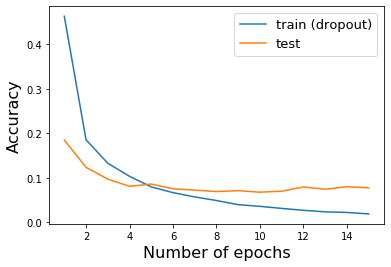

In [28]:
epochs = np.arange(len(train_loss_log))+1
plt.plot(epochs, train_loss_log, label = 'train (dropout)')
plt.plot(epochs, val_loss_log, label = 'test')
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Saving the best model

In [29]:
model_architecture = {'out_size':10, 'n_epochs':best_params['n_epochs'],'h_sizes':best_params['h_sizes'], 
                      'dropout':best_params['dropout'], 'act':best_params['act']}

In [32]:
np.save('model_architecture', model_architecture)
torch.save(best_net.state_dict(), 'params.pth')

## Loading model (just for check)

In [43]:
architecture = np.load('model_architecture.npy', allow_pickle=True).item()
best_net2 = Net(**architecture)
best_net2.load_state_dict(torch.load('params.pth'))

<All keys matched successfully>

In [44]:
accuracy, predictions = eval_accuracy(best_net2, x_test,y_test,return_predictions=True)
print("Accuracy obtained {:.2f}%".format(accuracy))

Accuracy obtained 98.23%


## Visualization and interpretation of NN

In [45]:
# let's consider our best model for visualization pourposes
print_parameters(best_params)

Parameters: 
out_size 	 10
n_epochs 	 15
loss 	 	 CrossEntropyLoss()
lr 	 	 0.003996024018867443
h_sizes 	 [784, 278, 94, 24]
penalty 	 0.0014430192249231507
dropout 	 0.08787206607182774
optimizer 	 <class 'torch.optim.adamax.Adamax'>
act 	 	 <function relu at 0x7f9e78b8c8c0>


We have 3 hidden layers, hence 4 matrices of weights W.

In [46]:
for i,p in enumerate(list(best_net.parameters())):
    print(i,p.shape)

0 torch.Size([278, 784])
1 torch.Size([278])
2 torch.Size([94, 278])
3 torch.Size([94])
4 torch.Size([24, 94])
5 torch.Size([24])
6 torch.Size([10, 24])
7 torch.Size([10])


We can see that torch saves both the weigth matrices and the biases in model.parameters(). We now forget about biases for the sake of visualization.

In [47]:
# I use deepcopy because I noticed that in the following process 
#I modified the network parameters even if I used detach
import copy

In [48]:
net_params = list(best_net.parameters())
W01 = copy.deepcopy(net_params[0].detach().numpy())
B1 = copy.deepcopy(net_params[1].detach().numpy())
W12 = copy.deepcopy(net_params[2].detach().numpy())
B2 = copy.deepcopy(net_params[3].detach().numpy())
W23 = copy.deepcopy(net_params[4].detach().numpy())
B3 = copy.deepcopy(net_params[5].detach().numpy())
W34 = copy.deepcopy(net_params[6].detach().numpy())
B4 = copy.deepcopy(net_params[7].detach().numpy())

In [49]:
def visualize_weights(weight_mat, show=True, vrange=None):
    if vrange == None:
        plt.imshow(weight_mat.T, cmap='RdBu_r')
    else:
        plt.imshow(weight_mat.T, cmap='RdBu_r', vmin=-vrange, vmax=vrange)
    plt.xticks([])
    plt.yticks([])
    if show:
        plt.colorbar()
        plt.show()

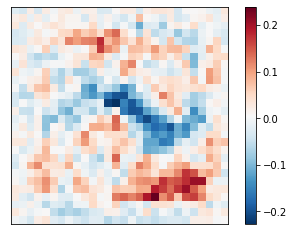

In [50]:
W01_0 = W01[0].reshape(28,28)
visualize_weights(W01_0)

In [51]:
PF_12 = np.matmul(W12,W01) 
PF_23 = np.matmul(W23,PF_12) 
PF_34 = np.matmul(W34,PF_23) 

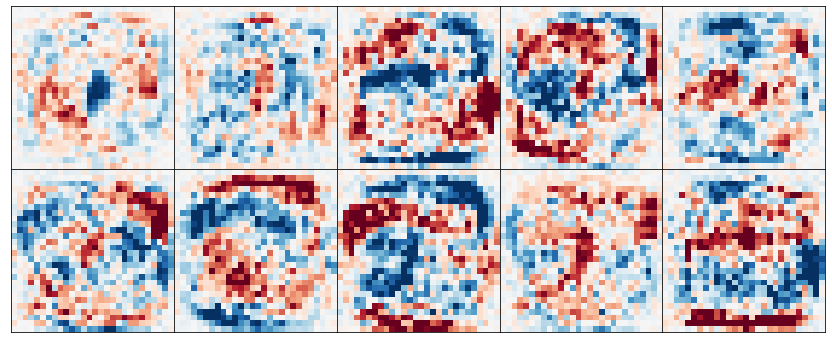

In [52]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(14.6,6))
#plt.suptitle("Perceptive field of the output layer", size = 22)

gs1 = gridspec.GridSpec(2,5)
gs1.update(wspace=0, hspace=0)

for i in range(10):
        ax1 = plt.subplot(gs1[i])
        visualize_weights(PF_34[i].reshape(28,28), show=False, vrange=5 )

        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])


plt.show()

Now we would like to see if multipliying the perceptive field for the correspondent number gives us something meaningful 

In [53]:
def show_digit(image):
    """
    Shows with the correct orientation black digits on white background.
    """
    reshaped_im = image.reshape(28,28)
    flipped_im = reshaped_im[:,:].T
    negative_im = np.ones((28,28))
    negative_im = negative_im - flipped_im
    plt.imshow(negative_im, cmap='gray')
    plt.show()

In [54]:
indexes = np.argmax(np.tile(labels[100:],(1,10)) == np.tile(np.arange(10),(len(labels[100:]),1)), axis=0)
first_digits = images[100:][indexes]

What I want to do is to take into account also the activation function of the neurons and their bias. In other words, I propagate the input and set to zero the weights instead of the output of the neurons, when the output should be zero.

layer1_act.shape:  (278, 784)


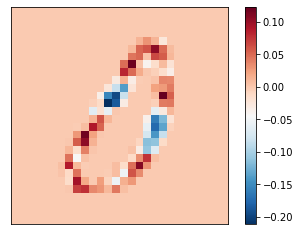

In [55]:
# activation of first neuron of the first hidden layer
layer1_act = W01*first_digits[0]
print("layer1_act.shape: ", layer1_act.shape) #278 neurons in the first layer
visualize_weights(layer1_act[0].reshape(28,28))

In [56]:
# we know that if the sum of all elements + the bias is smaller than 1 with relu we have no activation at all
# thus I decided to mask that activation for the following layers
print("W01.shape: ", W01.shape)
print("first_digits[0].shape: ", first_digits[0].shape)
print("B1.shape: ", B1.shape)
mask1 = np.matmul(W01,first_digits[0]) + B1 < 0
print("mask1.shape: ", mask1.shape)
print("W12.shape: ", W12.shape)
W12_biased = copy.deepcopy(W12)
W12_biased[:,mask1] = 0

W01.shape:  (278, 784)
first_digits[0].shape:  (784,)
B1.shape:  (278,)
mask1.shape:  (278,)
W12.shape:  (94, 278)


W12_biased.shape:  (94, 278)
layer1_act.shape:  (278, 784)
layer2_act.shape:  (94, 784)


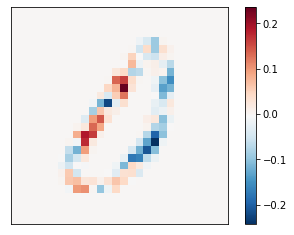

In [57]:
print("W12_biased.shape: ", W12_biased.shape)
print("layer1_act.shape: ", layer1_act.shape)
layer2_act = np.matmul(W12_biased,layer1_act)
print("layer2_act.shape: ", layer2_act.shape)
visualize_weights(layer2_act[0].reshape(28,28))

In [58]:
mask2 = layer2_act.sum(axis=1) + B2 < 0
print("mask2.shape: ", mask2.shape)
print("W23.shape: ", W23.shape)
W23_biased = copy.deepcopy(W23)
W23_biased[:,mask2] = 0

mask2.shape:  (94,)
W23.shape:  (24, 94)


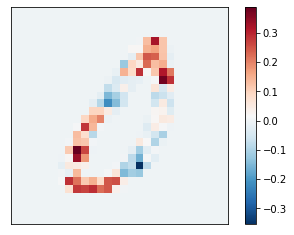

In [59]:
layer3_act = np.matmul(W23_biased,layer2_act)
visualize_weights(layer3_act[0].reshape(28,28))

mask3.shape:  (24,)
W34.shape:  (10, 24)


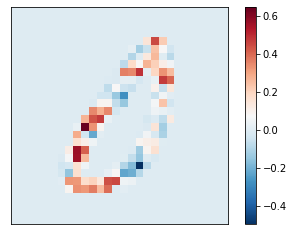

In [60]:
mask3 = layer3_act.sum(axis=1) + B3 < 0
print("mask3.shape: ", mask3.shape)
print("W34.shape: ", W34.shape)
W34_biased = copy.deepcopy(W34)
W34_biased[:,mask3] = 0
layer4_act = np.matmul(W34_biased,layer3_act)
visualize_weights(layer4_act[0].reshape(28,28))

In [61]:
def out_layer_act(input_im, net_params):
    W01 = copy.deepcopy(net_params[0].detach().numpy())
    B1 = copy.deepcopy(net_params[1].detach().numpy())
    W12 = copy.deepcopy(net_params[2].detach().numpy())
    B2 = copy.deepcopy(net_params[3].detach().numpy())
    W23 = copy.deepcopy(net_params[4].detach().numpy())
    B3 = copy.deepcopy(net_params[5].detach().numpy())
    W34 = copy.deepcopy(net_params[6].detach().numpy())
    B4 = copy.deepcopy(net_params[7].detach().numpy())
    
    layer1_act = W01*input_im
    mask1 = np.matmul(W01,input_im) + B1 < 0
    W12_biased = copy.deepcopy(W12)
    W12_biased[:,mask1] = 0
    layer2_act = np.matmul(W12_biased,layer1_act)
    mask2 = layer2_act.sum(axis=1) + B2 < 0
    W23_biased = copy.deepcopy(W23)
    W23_biased[:,mask2] = 0
    layer3_act = np.matmul(W23_biased,layer2_act)
    mask3 = layer3_act.sum(axis=1) + B3 < 0
    W34_biased = copy.deepcopy(W34)
    W34_biased[:,mask3] = 0
    layer4_act = np.matmul(W34_biased,layer3_act)
    return layer4_act

In [62]:
activation_i  = out_layer_act(first_digits[0], net_params)

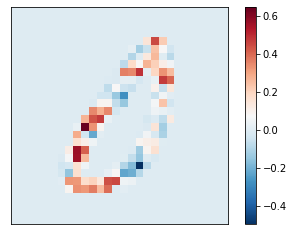

In [63]:
visualize_weights(activation_i[0].reshape(28,28))

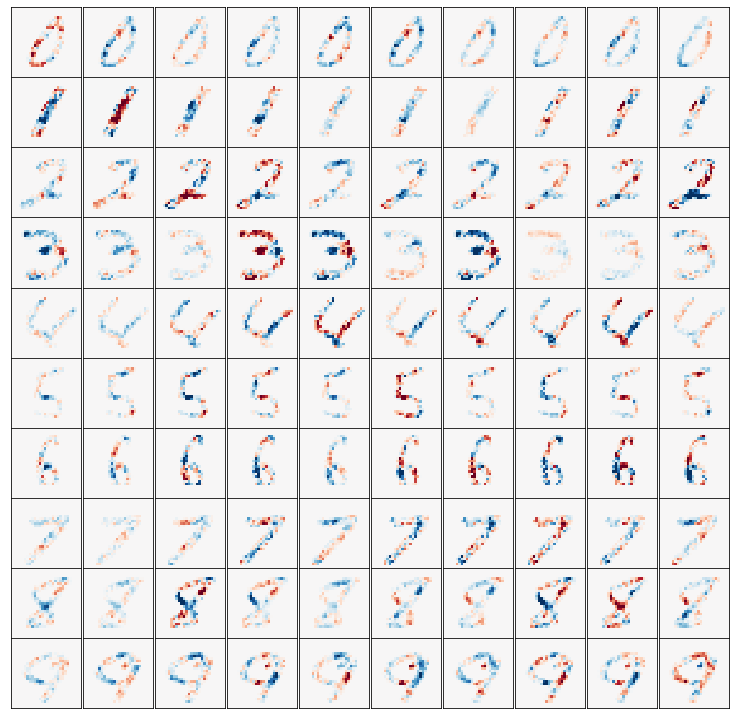

In [64]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(12.9,12.9))
#plt.suptitle("Activation of the perceptive field", size = 24, y=0.92)

gs1 = gridspec.GridSpec(10,10)
gs1.update(wspace=0, hspace=0)

for i in range(10):
    activation_i = out_layer_act(first_digits[i], net_params)
    for j in range(10):
        ax1 = plt.subplot(gs1[10*(i)+j])
        activation_ij = activation_i[j]
        visualize_weights(activation_ij.reshape(28,28), show=False, vrange=0.6)

        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])


plt.show()

## Optimizing input images

In [701]:
import warnings
warnings.filterwarnings("ignore")

In [702]:
def dream_image(neuron, iterations=1000, lr=0.01):
    input_image = np.random.rand(784).astype('float32')
    input_im = torch.tensor(input_image, requires_grad=True).view(1,-1)


    for i in range(iterations):
        if i != 0:
            input_im = updated_im.detach()
        input_im = Variable(input_im, requires_grad=True)
        out = best_net.forward(input_im)
        objective = out[0,neuron]
        objective.backward()
        updated_im = input_im + lr*input_im.grad #gradient ascent
        updated_im = F.softmax(updated_im) #keep it between 0 and 1
    return updated_im.detach()

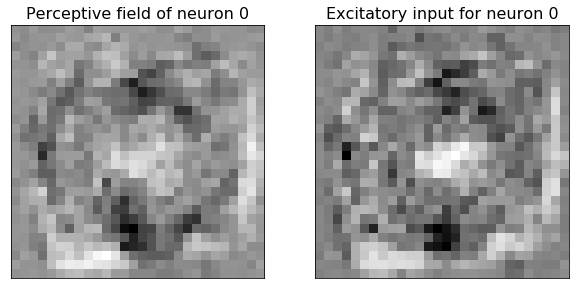

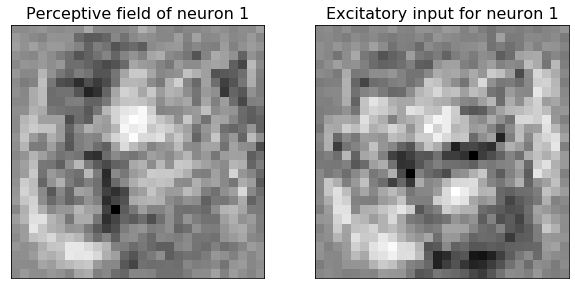

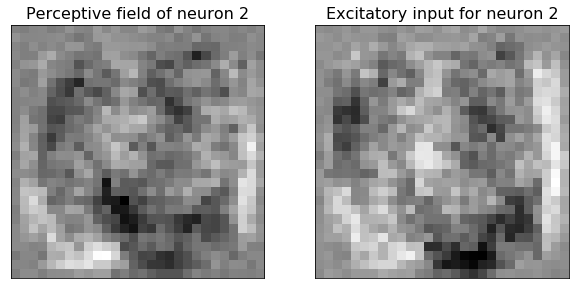

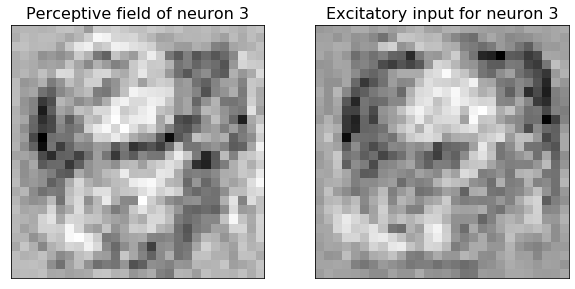

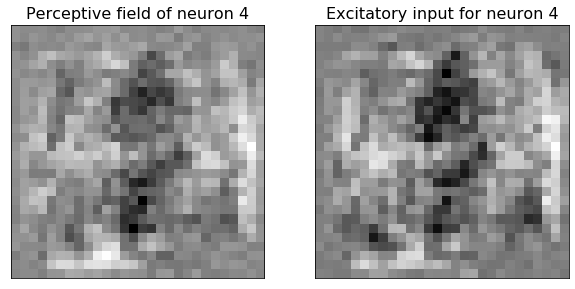

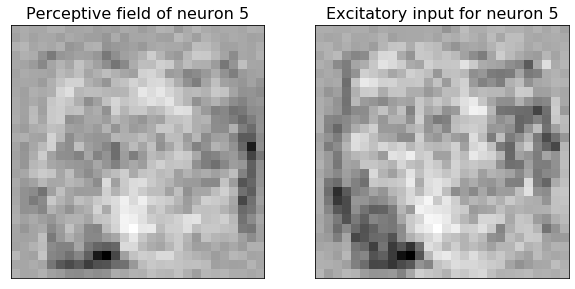

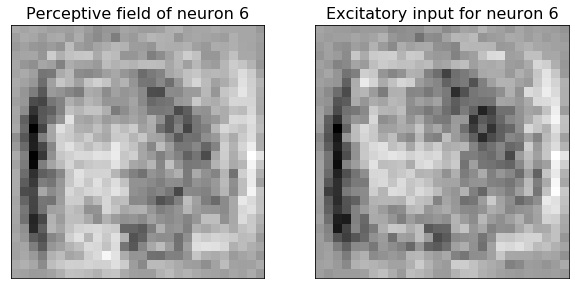

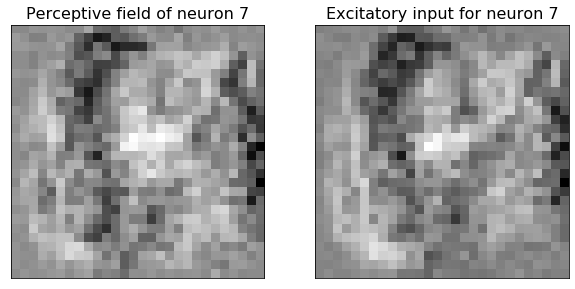

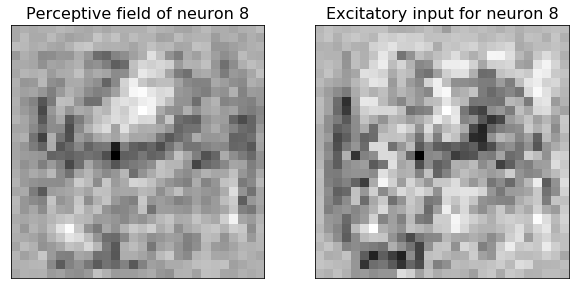

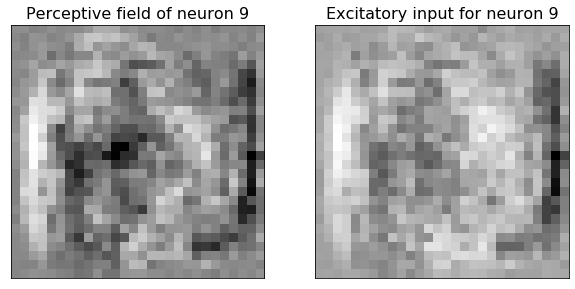

In [703]:
for neuron in range(10):

    opt_im = dream_image(neuron)

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(opt_im.reshape(28,28), cmap='Greys')
    plt.title("Perceptive field of neuron %d"%neuron, fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(PF_34[neuron].reshape(28,28), cmap='Greys')
    plt.title("Excitatory input for neuron %d"%neuron, fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.show()